## 2. Creación del grafo

El segundo paso, y en el que se va a centrar principalmente el proyecto, va a ser la creación del grafo.
Para ello vamos a crear un grafo donde cada nodo sea un artista y los ejes sean los usuarios comunes entre cada par de artistas.

### 2.1 Matriz de adyacencia

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_artists = pd.read_csv('artists-v2.dat', header=0, sep='\t', usecols=[0,1,2])
df_users = pd.read_csv('user_artists.dat', header=0, sep='\t')

In [3]:
df_users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
df_artists.head()

,artistID,name,freq
0,89,Lady Gaga,611
1,289,Britney Spears,522
2,288,Rihanna,484
3,227,The Beatles,480
4,300,Katy Perry,473


In [5]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

Creamos una matriz de zeros de tamaño (num_artists x num_artists).

In [6]:
size = len(df_artists.index)
matrix = np.zeros((size,size))

Cogemos el ID de dos artistas.

In [7]:
artistA = df_artists.iloc[0]['artistID']
artistB = df_artists.iloc[1]['artistID']
print(artistA, artistB)

89 289


Hacemos para cada uno un sub-dataframe del dataframe users.

In [8]:
df_artistA = df_users.loc[df_users['artistID'] == artistA, ['userID']]
df_artistB = df_users.loc[df_users['artistID'] == artistB, ['userID']]

In [9]:
df_artistA.head()

,userID
38,2
252,7
301,8
451,11
552,13


Y hacemos un **innerjoin**, para saber cuál es el número de usuarios en común que tienen. Es lo que usaremos como pesos de los ejes de nuestro grafo.

In [10]:
w = len(pd.merge(df_artistA, df_artistB, on='userID', how='inner').index)
print(w)

436


Como método alternativo, he creado la función **calculate_weight** que calcula el número de coincidencias entre ambos dataframes usando **búsqueda binaria**.

In [11]:
def binary_search(value, array):
    i = 0
    j = len(array)-1
    found = False

    while i <= j and not found:
        mid = (i + j) // 2
        if array[mid] == value:
            return True
        else:
            if value < array[mid]:
                j = mid - 1
            else:
                i = mid + 1
    return False

def calculate_weight(arrayA, arrayB): 
    weight = 0
    i=0
    for value in arrayA:
        if value > arrayB[-1]:
            return weight
        if binary_search(value, arrayB):
            weight +=1
        
    return weight

In [12]:
w2 = calculate_weight(df_artistA.values, df_artistB.values)
print(w2)

436


Ahora, para construir la matriz de adyacencia, juntaremos los pasos anteriores en un bucle, de manera que calculemos el peso para cada par de artistas. Para agilizarlo un poco, he decidido crear una lista que contiene los dataframes de usuarios de cada artista.

In [13]:
#np.set_printoptions(threshold=np.nan)
#print(matrix)

In [14]:
def calculate_matrix(df_artists, df_users):
    
    num_artists = len(df_artists.index)
    dataframes_list = []
    
    for i in range(num_artists):
        artist = df_artists.iloc[i]['artistID']
        df_artist = df_users.loc[df_users['artistID'] == artist, ['userID']]
        dataframes_list.append(df_artist)
    
    size = len(df_artists.index)
    matrix = np.zeros((size,size))
    
    for i in range(num_artists):
        df_artistA = dataframes_list[i]
        for j in range(i+1,num_artists):
            df_artistB = dataframes_list[j]
            #weight = len(pd.merge(df_artistA, df_artistB, on='userID', how='inner').index)
            weight = calculate_weight(df_artistA.values, df_artistB.values)
            matrix[i][j]=weight
        print(i)
    
    return matrix
        
#m = calculate_matrix(df_artists, df_users)
#m[0]

In [15]:
#np.savetxt('matrix.txt',m,fmt='%.0f')

https://codereview.stackexchange.com/questions/147136/binary-search-a-sorted-list-of-integers

Ahora que ya tenemos guardada en un fichero la matriz, podemos cargarla fácilmente.

In [16]:
m = np.loadtxt('matrix.txt')

### 2.2. Generación del Grafo

They can be represented as two lists:

1. A **node list**: a list of 2-tuples where the first element of each tuple is the representation of the node, and the second element is a dictionary of metadata associated with the node.
2. An **edge list**: a list of 3-tuples where the first two elements are the nodes that are connected together, and the third element is a dictionary of metadata associated with the edge.

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nxviz import MatrixPlot

df_artists = pd.read_csv('artists-v2.dat', header=0, sep='\t', usecols=[0,2])
df_tags = pd.read_csv('artist_tags-v2.dat', header=0, sep= '\t')
df_users = pd.read_csv('user_artists.dat', header=0, sep='\t', usecols=[0,1])

m = np.loadtxt('matrix.txt')

In [21]:
df_artists = df_artists.join(df_tags.set_index('artistID'), on='artistID')

In [22]:
df_artists.head()

,artistID,freq,name,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10
0,89,611,lady gaga,pop,dance,electronic,electropop,NaN,NaN,NaN,NaN,NaN,NaN
1,289,522,britney spears,pop,dance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,288,484,rihanna,pop,rnb,dance,hip-hop,reggae,NaN,NaN,NaN,NaN,NaN
3,227,480,the beatles,classic rock,rock,pop,psychedelic,psychedelic rock,NaN,NaN,NaN,NaN,NaN
4,300,473,katy perry,pop,pop rock,indie,rock,dance,NaN,NaN,NaN,NaN,NaN


### NetworkX

In [23]:
def generate_graph(matrix, df_artists, threshold):
    graph = nx.Graph()
    num = len(df_artists.index)
    #num=1000
    for index, artistA in df_artists[:num].iterrows():
        graph.add_node(artistA['name'], attr_dict = {'genre1': artistA['tag1'],
                                                     'genre2': artistA['tag2'],
                                                     'genre3': artistA['tag3'], 
                                                     'freq': artistA['freq']})

    i = 0
    for index, artistA in df_artists[:num].iterrows():
        for j in range(i+1, num):
            artistB = df_artists.iloc[j]
            w = matrix[i][j]
            if w > threshold:
                graph.add_edge(artistA['name'], artistB['name'], weight = w)
                
        i += 1
    return graph

In [24]:
G = generate_graph(m, df_artists, 0)

/home/luna/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


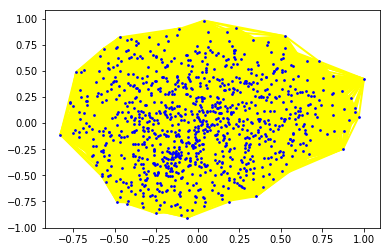

In [23]:
#nx.draw(G, with_labels=True)
pos = nx.layout.spring_layout(G)
node_sizes = 3
M = G.number_of_edges()
#edge_colors = range(2, M + 2)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue', with_labels = True)
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',arrowsize=10, edge_color='yellow', 
                               edge_cmap=plt.cm.Blues, width=2)

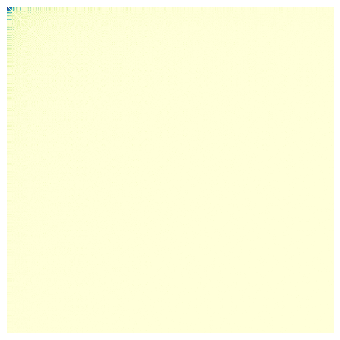

In [24]:
mplot = MatrixPlot(G)
mplot.draw()
plt.show()

### 3. Estadísticas del grafo

https://networkx.github.io/documentation/networkx-1.7/reference/algorithms.clustering.html

### 3.1. Estadísticas

Vamos a obtener algunas métricas interesantes de nuestro grafo, que nos permitan tener una idea general de cómo es nuestro grafo.

**1. Número de nodos**

In [15]:
nx.number_of_nodes(G)

4562

**2. Número de ejes**

In [16]:
nx.number_of_edges(G)

696740

**3. Grado máximo**

In [24]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[0:100]

[('the beatles', 3262),
 ('radiohead', 2908),
 ('muse', 2890),
 ('lady gaga', 2814),
 ('coldplay', 2749),
 ('nirvana', 2489),
 ('the killers', 2435),
 ('depeche mode', 2416),
 ('the cure', 2364),
 ('paramore', 2360),
 ('madonna', 2357),
 ('pink floyd', 2334),
 ('red hot chili peppers', 2322),
 ('linkin park', 2310),
 ('placebo', 2299),
 ('britney spears', 2277),
 ('michael jackson', 2268),
 ('green day', 2233),
 ('metallica', 2189),
 ('queen', 2185),
 ('katy perry', 2184),
 ('avril lavigne', 2116),
 ('kings of leon', 2114),
 ('arctic monkeys', 2084),
 ('system of a down', 2074),
 ('david bowie', 2042),
 ('rihanna', 2026),
 ('oasis', 2017),
 ('u2', 1984),
 ('björk', 1982),
 ('led zeppelin', 1970),
 ('30 seconds to mars', 1961),
 ('evanescence', 1959),
 ('daft punk', 1945),
 ('eminem', 1911),
 ('ac/dc', 1879),
 ('beyoncé', 1877),
 ('foo fighters', 1871),
 ('nine inch nails', 1852),
 ('the smiths', 1850),
 ('lily allen', 1847),
 ("guns n' roses", 1835),
 ('ke$ha', 1819),
 ('sigur rós', 18

**4. Grado promedio**

Es el número de ejes esperado en un nodo cualquiera. Depende de la densidad de la red y se calcula según la siguiente fórmula: 

k = 2E/N

In [18]:
2*nx.number_of_edges(G)/nx.number_of_nodes(G)

305.4537483559842

**5. Asortatividad**

La asortatividad es el coeficiente de correlación de Pearson entre pares de nodos. Un valor positivo de r indica una correlación entre nodos de grado parecido, mientras que valores negativos indican correlación entre nodos de grado distinto.

(230-231)  
En una red "asortativa" encontramos un corazón con nodos con gran densidad y, cuanto más nos alejamos del corazón, más dispersos encontramos los nodos.

En una red "disasortativa" los nodos no se encuentran ordenados según su grado, ni se pueden ordenar mediante él.

In [25]:
nx.degree_assortativity_coefficient(G)

-0.1670364672174702

**6. Número de triángulos (3-clique)**

In [20]:
nx.triangles(G)

{'lady gaga': 463359,
 'britney spears': 367368,
 'rihanna': 322509,
 'the beatles': 530300,
 'katy perry': 354191,
 'madonna': 383410,
 'avril lavigne': 346111,
 'christina aguilera': 279295,
 'muse': 485050,
 'paramore': 395984,
 'beyoncé': 297677,
 'radiohead': 467386,
 'coldplay': 461733,
 'ke$ha': 291558,
 'shakira': 260663,
 'p!nk': 279298,
 'the killers': 414452,
 'black eyed peas': 275900,
 'kylie minogue': 275636,
 'miley cyrus': 221553,
 'depeche mode': 378829,
 'linkin park': 381743,
 'michael jackson': 374060,
 'kelly clarkson': 237188,
 'nirvana': 417018,
 'pink floyd': 369229,
 'glee cast': 265500,
 'arctic monkeys': 351413,
 'taylor swift': 247946,
 'lily allen': 309614,
 'placebo': 384128,
 'mariah carey': 202892,
 'green day': 379237,
 'kings of leon': 366443,
 'the pussycat dolls': 188967,
 'the cure': 381338,
 'evanescence': 320323,
 'metallica': 345067,
 'red hot chili peppers': 388916,
 '30 seconds to mars': 327532,
 'oasis': 342942,
 'jennifer lopez': 166796,
 'qu

**7. Promedio de triángulos formados por un eje**

In [21]:
nx.transitivity(G)

0.2815371315722328

**8. Coeficiente de clustering local promedio**

In [99]:
nx.clustering(G)

{'lady gaga': 0.11707219829954893,
 'britney spears': 0.14177381671841824,
 'rihanna': 0.15721984570948047,
 'the beatles': 0.09970498380146543,
 'katy perry': 0.1485802714616274,
 'madonna': 0.1380888341125989,
 'avril lavigne': 0.15467472862397047,
 'christina aguilera': 0.17482401485248295,
 'muse': 0.11619063360485603,
 'paramore': 0.14225504918056345,
 'beyoncé': 0.1690745223573888,
 'radiohead': 0.1105773712269724,
 'coldplay': 0.12224453195366,
 'ke$ha': 0.17633088212614553,
 'shakira': 0.18816629129129128,
 'p!nk': 0.18167129683533229,
 'the killers': 0.13985715707828353,
 'black eyed peas': 0.18131752582739677,
 'kylie minogue': 0.1805226088790329,
 'miley cyrus': 0.21177310618334685,
 'depeche mode': 0.12985514101984014,
 'linkin park': 0.14314136852032044,
 'michael jackson': 0.1455045904391589,
 'kelly clarkson': 0.20041386035043782,
 'nirvana': 0.13468198982274418,
 'pink floyd': 0.1356157747103791,
 'glee cast': 0.19515960086002537,
 'arctic monkeys': 0.1619052138553301,


**9. Coeficiente global de clustering**

In [100]:
nx.average_clustering(G)

0.5201677718488529

#### 10. Diametro

In [25]:
print("Diameter: %d" % nx.diameter(G))

Diameter: 3


#### 11. Distribución del grado

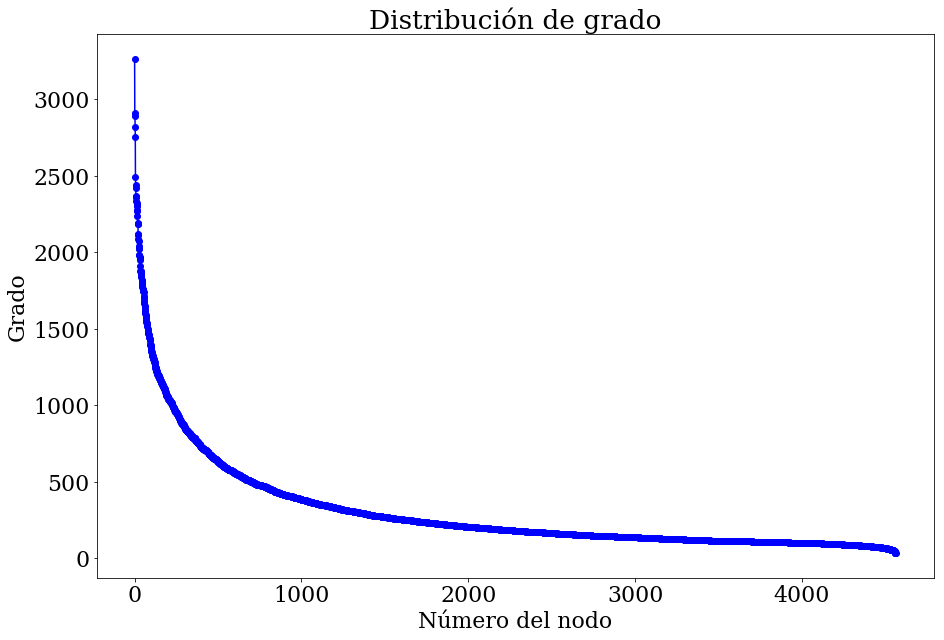

In [34]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.plot(degree_sequence,'b-',marker='o')
plt.title("Distribución de grado")
plt.ylabel("Grado")
plt.xlabel("Número del nodo")
plt.savefig("distribucion_grado.jpg")

#### 12. Diagrama de fuerza (strength plot)

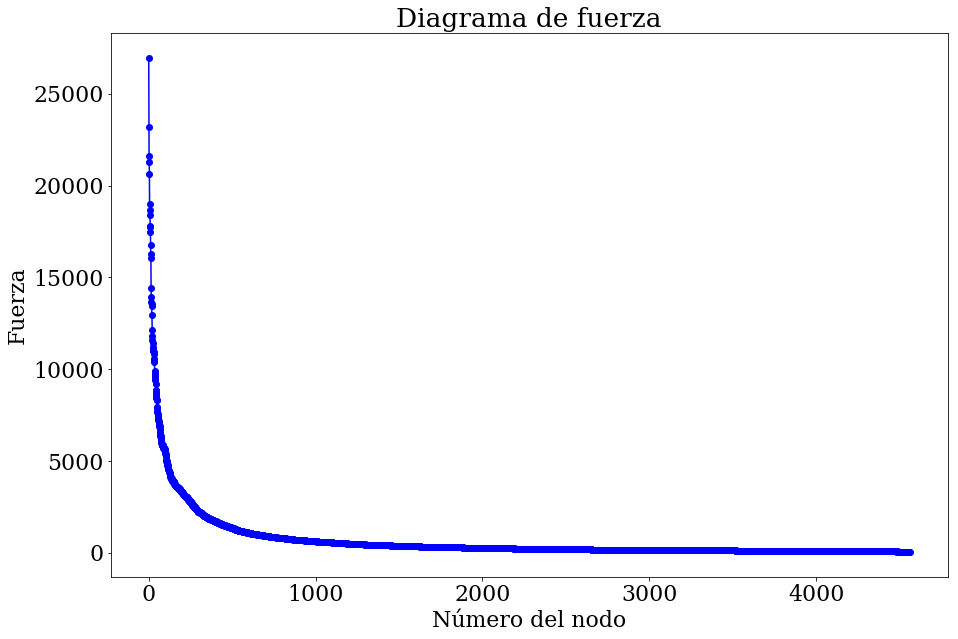

In [35]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))

strength_sequence = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
plt.plot(strength_sequence,'b-',marker='o')
plt.title("Diagrama de fuerza")
plt.ylabel("Fuerza")
plt.xlabel("Número del nodo")
plt.savefig("diagrama_fuerza.jpg")

## 4. Visualización: Heatmap

Para poder tener una idea de lo que nos muestra el grafo vamos a realizar un heatmap. El heatmap del grafo, pero, no nos resulta muy útil, tiene demasiados artistas y eso hace que al final solo veamos un cuadrado con muchos puntitos que poco nos dice de nuestra red. 

Por eso vamos a realizar un heatmap con los géneros musicales en lugar de con los artistas. Lo que vamos a hacer es agrupar los artistas según su género musical, de manera que lo que veamos representado sean las relaciones entre géneros.

Esto lo conseguiremos de la siguiente manera:

1. Filtramos las filas según el género x. (Gx)
2. Sumamos el valor de las columnas.  (opt. normalizar)
3. Para cada género y, filtramos por columnas según Gy.
4. Repetimos el proceso para cada x pertenece a TODOX

Por último rellenamos la matriz completa para poder hacer la visualización.


In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from nxviz import MatrixPlot
import seaborn as sns
from matplotlib import pyplot as plt

df_artists = pd.read_csv('artists-v2.dat', header=0, sep='\t', usecols=[0,2])
df_tags = pd.read_csv('artist_tags-v2.dat', header=0, sep= '\t')
df_users = pd.read_csv('user_artists.dat', header=0, sep='\t', usecols=[0,1])
df_artists = df_artists.join(df_tags.set_index('artistID'), on='artistID')

list_tags = pd.read_csv('tags-sorted.dat')
list_tags = list_tags.tag.tolist()

list_tags_original = pd.read_csv('tags-v3.dat')
list_tags_original = list_tags_original.tag.tolist()

m = np.loadtxt('matrix.txt')
m_perc = np.loadtxt('matrix_percentage.txt')

### 4.1. Matriz agrupada por géneros

In [28]:
m[:10, :10]

array([[  0., 436., 414., 103., 396., 310., 299., 345., 128., 222.],
       [  0.,   0., 413.,  59., 380., 310., 298., 360.,  86., 205.],
       [  0.,   0.,   0.,  46., 358., 277., 283., 350.,  68., 189.],
       [  0.,   0.,   0.,   0.,  61.,  83.,  61.,  42., 162.,  80.],
       [  0.,   0.,   0.,   0.,   0., 243., 298., 316.,  80., 220.],
       [  0.,   0.,   0.,   0.,   0.,   0., 192., 267.,  71., 106.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 246.,  83., 218.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  52., 150.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 116.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [29]:
mask = (df_artists['tag1'] == 'pop')
mask[:14]

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13     True
Name: tag1, dtype: bool

In [30]:
m_copy = m.copy()
m_rows = m_copy * mask[:, None]

In [31]:
m_sum = m_rows.sum(axis = 0) 

In [32]:
m_sum[0:14]

array([   0.,  436.,  827.,  208., 1134., 1140., 1370., 1884.,  568.,
       1310., 2110.,  244.,  600., 1915.])

In [33]:
mask = (df_artists['tag1'] == 'rock')
m_cols = m_sum * mask

In [34]:
m_cols[:10]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9    1310.0
Name: tag1, dtype: float64

In [35]:
w1 = m_cols.sum()
w1

33406.0

In [36]:
maskA = (df_artists['tag1'] == 'rock')
m_rows = m_copy*maskA[:, None]
m_sum = m_rows.sum(axis = 0)             
maskB = (df_artists['tag1'] == 'pop')
m_cols = m_sum*maskB
w2 = m_cols.sum()
w = w1+w2

In [37]:
print(w1,w2,w)

33406.0 22335.0 55741.0


In [38]:
def create_genre_matrix(matrix, df, tags, colA=1, colB=1):
    str_colA = 'tag'+str(colA)
    str_colB = 'tag'+str(colB)
    coef = 1./colA * 1./colB
    
    num_tags = len(tags)
    genre_matrix = np.zeros((num_tags, num_tags))
    i = 0
    for tagA in tags:
        j = 0
        mask = (df[str_colA] == tagA)
        matrix_rows = matrix*mask[:, None]
        matrix_sum = matrix_rows.sum(axis = 0) 
        
        for tagB in tags:
            mask = (df[str_colB] == tagB)
            matrix_cols = matrix_sum*mask
            weight1 = matrix_cols.sum()
            weight2 = genre_matrix[j,i]
            weight = weight1+weight2
            genre_matrix[i,j] = weight
            genre_matrix[j,i] = weight

            j += 1
            
        i+=1
        
    genre_matrix = genre_matrix*coef
    return genre_matrix
            
m_genres = create_genre_matrix(m, df_artists, list_tags)            

In [39]:
m_genres[:4,:4]

array([[  16.,    2.,    3.,    2.],
       [   2.,  947.,  917.,   15.],
       [   3.,  917., 1006.,   38.],
       [   2.,   15.,   38.,  785.]])

In [40]:
total_weight = (m.sum(axis = 0)).sum()
total_weight_genres = (m_genres.sum(axis = 0)).sum()

print(total_weight,total_weight_genres)

1625340.0 2938675.0


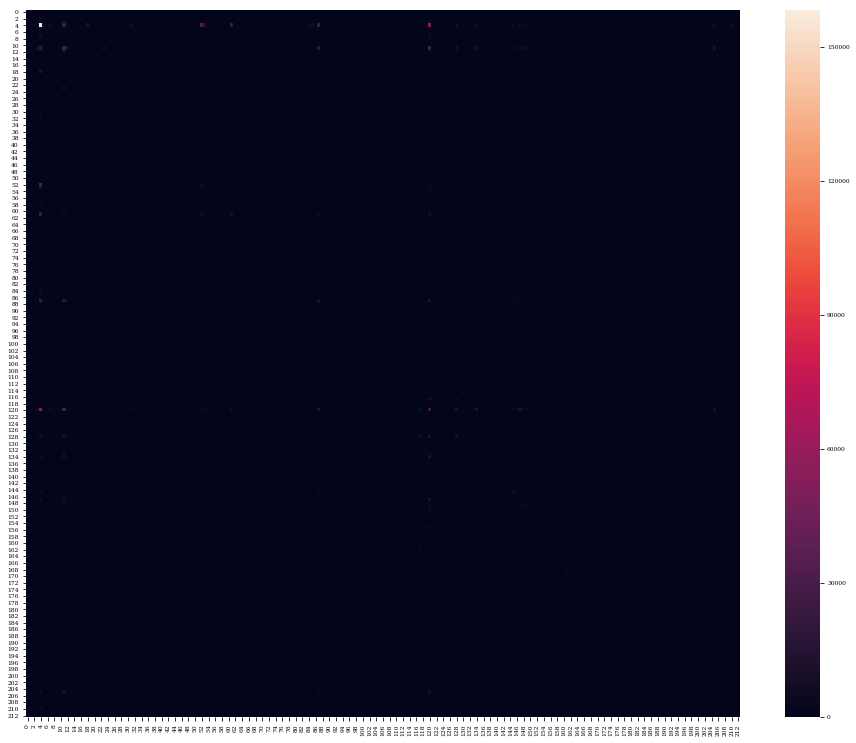

In [70]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(m_genres)
plt.savefig('m_genres1.png')

### 4.2. Matriz con porcentajes (% usuarios comunes entre artistas)

In [42]:
def matrix_to_percentage(matrix, df):
    matrix_perc = matrix.copy()
    i=0
    for idx,artistA in df.iterrows():
        listenersA = artistA['freq']
        j=0
        for idx,artistB in df.iterrows():
            listenersB = artistB['freq']
            listeners = min(listenersA, listenersB)
            matrix_perc[i,j] = matrix[i,j]/listeners
            j+=1
        i+=1
    return matrix

#m_perc = matrix_to_percentage(m, df_artists)
#np.savetxt('matrix_percentage.txt',m_perc,fmt='%.6f')

In [43]:
def matrix_threshold(matrix, threshold):
    matrix[matrix > threshold] = 1
    matrix[matrix <= threshold] = 0
    return matrix

In [44]:
m_perc = matrix_threshold(m_perc, 0)

In [45]:
m_perc[:5,:5]

array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [46]:
m_genres_perc = create_genre_matrix(m_perc, df_artists, list_tags)            

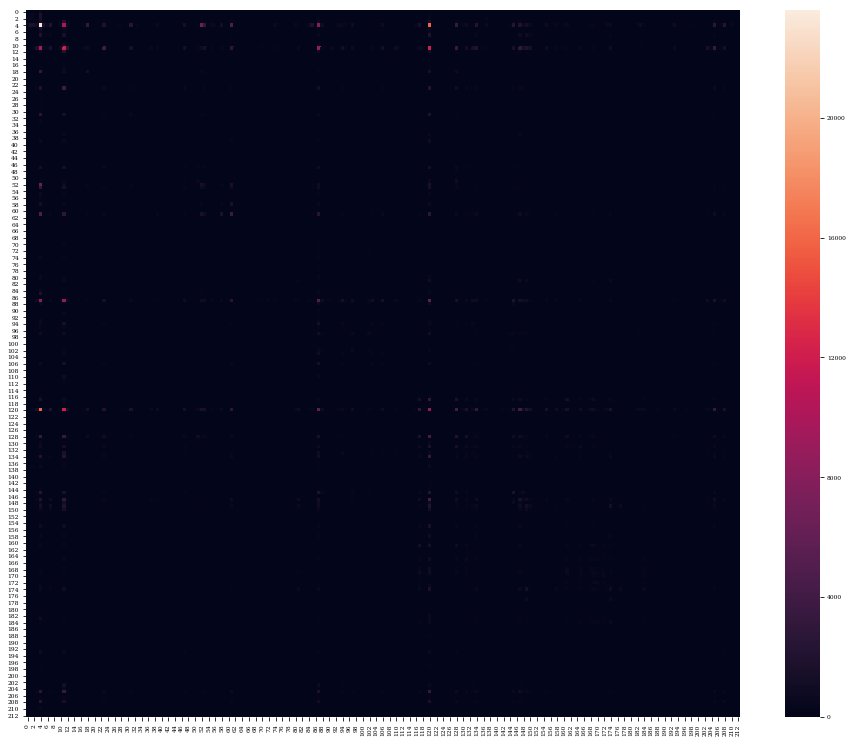

In [69]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(m_genres_perc)
plt.savefig('m_genres2.png')

### 4.3. Matriz normalizada según número de artistas

Número de oyentes comunes entre artistas, agrupados por género, dividido entre el número de artistas que se está considerando.

In [50]:
def create_genre_matrix_normalized(matrix, df, tags, colA=1, colB=1):
    str_colA = 'tag'+str(colA)
    str_colB = 'tag'+str(colB)
    coef = 1./colA * 1./colB
    
    num_tags = len(tags)
    genre_matrix = np.zeros((num_tags, num_tags))
    i = 0
    for tagA in tags:
        j = 0
        maskA = (df[str_colA] == tagA)
        num_artistsA = maskA.sum()
        matrix_rows = matrix*maskA[:, None]
        matrix_sum = matrix_rows.sum(axis = 0) 
        
        for tagB in tags:
            maskB = (df[str_colB] == tagB)
            num_artistsB = maskB.sum()
            num_artists = num_artistsA*num_artistsB
            if num_artists == 0:
                num_artists = 1
            matrix_cols = matrix_sum*maskB
            weight1 = matrix_cols.sum()
            weight2 = genre_matrix[j,i]
            weight = (weight1+weight2)/num_artists
            genre_matrix[i,j] = weight
            genre_matrix[j,i] = weight

            j += 1
            
        i+=1
    genre_matrix[np.isnan(genre_matrix)] = 0
    genre_matrix = genre_matrix*coef
    
    return genre_matrix

In [51]:
m_genres_norm = create_genre_matrix_normalized(m, df_artists, list_tags)            

In [52]:
m_genres_norm[:5,:5]

array([[6.40000000e-01, 7.81250000e-05, 1.62162162e-02, 1.53846154e-02,
        3.29711432e-01],
       [7.81250000e-05, 9.24804688e-01, 4.83354210e-01, 1.80288462e-02,
        2.46362493e-01],
       [1.62162162e-02, 4.83354210e-01, 7.34842951e-01, 3.74241985e-02,
        2.25783575e-01],
       [1.53846154e-02, 1.80288462e-02, 3.74241985e-02, 1.16124260e+00,
        1.28917292e-01],
       [3.29711432e-01, 2.46362493e-01, 2.25783575e-01, 1.28917292e-01,
        8.24617919e-01]])

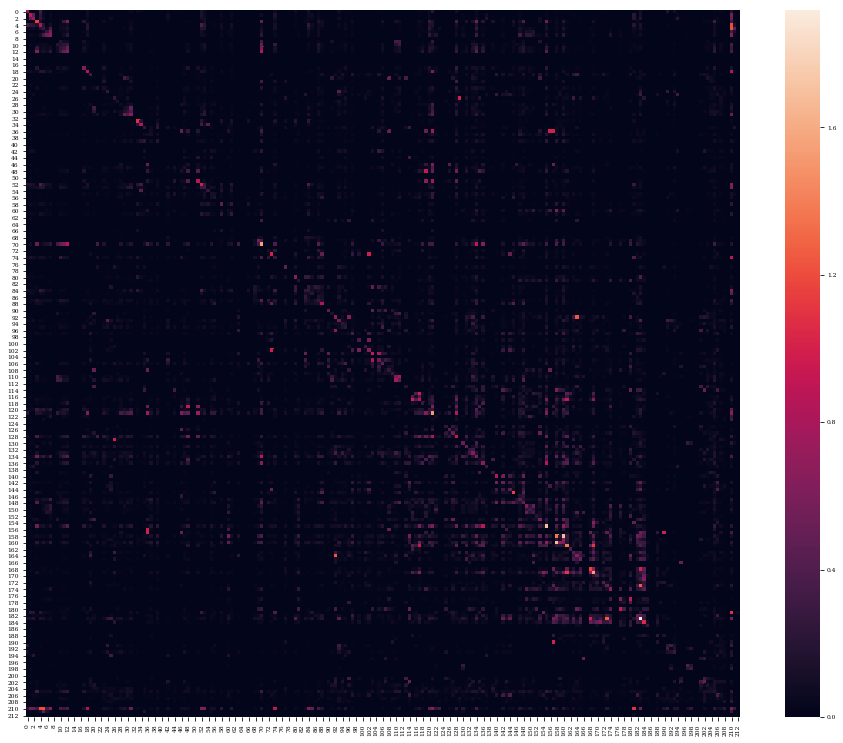

In [67]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(m_genres_norm)
plt.savefig('m_genres3.png')

 ### 4.4 Matriz con porcentajes normalizada según número de artistas
 
 Número de grupos que tienen al menos x% oyentes en común, divido entre el número de artistas de los géneros que se están contemplando. 

In [54]:
m_genres_perc_norm = create_genre_matrix_normalized(m_perc, df_artists, list_tags)            

In [55]:
m_genres_perc_norm

array([[3.60000000e-01, 7.81250000e-05, 1.08108108e-02, ...,
        1.00000000e-01, 0.00000000e+00, 0.00000000e+00],
       [7.81250000e-05, 3.60351562e-01, 2.08786066e-01, ...,
        1.56277127e-01, 3.12500000e-02, 2.44140625e-04],
       [1.08108108e-02, 2.08786066e-01, 3.09715121e-01, ...,
        1.48689230e-01, 0.00000000e+00, 1.82615047e-04],
       ...,
       [1.00000000e-01, 1.56277127e-01, 1.48689230e-01, ...,
        2.77777778e-01, 2.77777778e-02, 1.38888889e-02],
       [0.00000000e+00, 3.12500000e-02, 0.00000000e+00, ...,
        2.77777778e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.44140625e-04, 1.82615047e-04, ...,
        1.38888889e-02, 0.00000000e+00, 0.00000000e+00]])

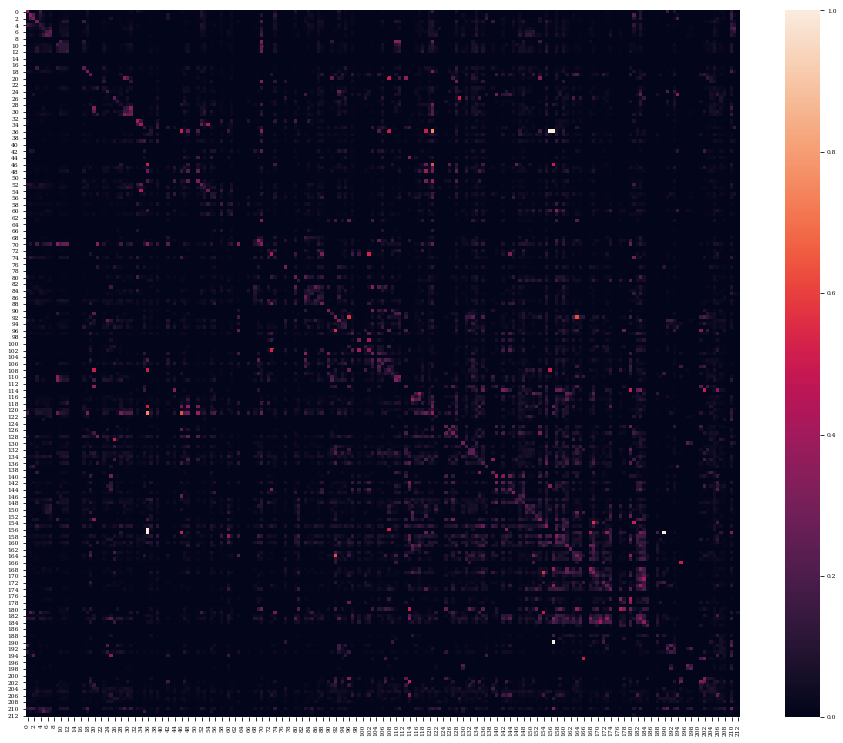

In [68]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(m_genres_perc_norm)
plt.savefig('m_genres4.png')

## 5. Matriz final: combinacion de los 3 tags más representativos

Ahora vamos a calcular la matriz resultante de sumar las 9 posibles combinaciones de tags (3 tags de cada artista). 
Todas las combinaciones no tienen el mismo peso. El tag más representativo tiene un peso de 1, el segundo más representativo de 1/2 y el tercero de 1/3.
Los pesos de cada tag se multiplican para obtener el peso de la matriz.
De esta manera, la matriz resultante es la suma de las 9 matrices cada una multiplicada por el peso correspondiente (1, 0.5, 0.3, 0.25, 0.16 0.11)


Esta matriz la vamos a calcular tanto sólo normalizada, como normalizada con porcentajes.

In [57]:
def compute_complete_matrix(matrix, df, tags):
    num_tags = len(tags)
    genre_matrix = np.zeros((num_tags, num_tags))
    
    for i in range(1,4):
        for j in range(1,4):
            genre_matrix = np.add(genre_matrix, create_genre_matrix_normalized(matrix, df, tags, i, j))
    return genre_matrix

### A. Normalizada

In [58]:
final_matrix = compute_complete_matrix(m, df_artists, list_tags)

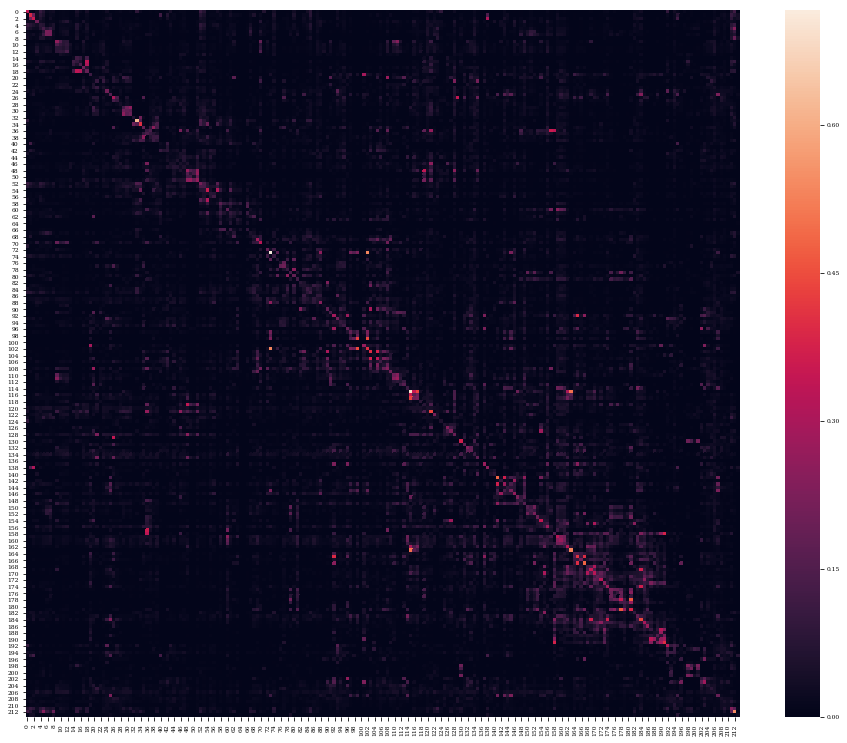

In [65]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(final_matrix)
plt.savefig('m_genres5.png')

### B. Normalizada con porcentajes

In [60]:
final_matrix = compute_complete_matrix(m_perc, df_artists, list_tags)

In [61]:
#np.savetxt('final_matrix.txt',final_matrix,fmt='%.9f')
final_matrix = np.loadtxt('final_matrix.txt')

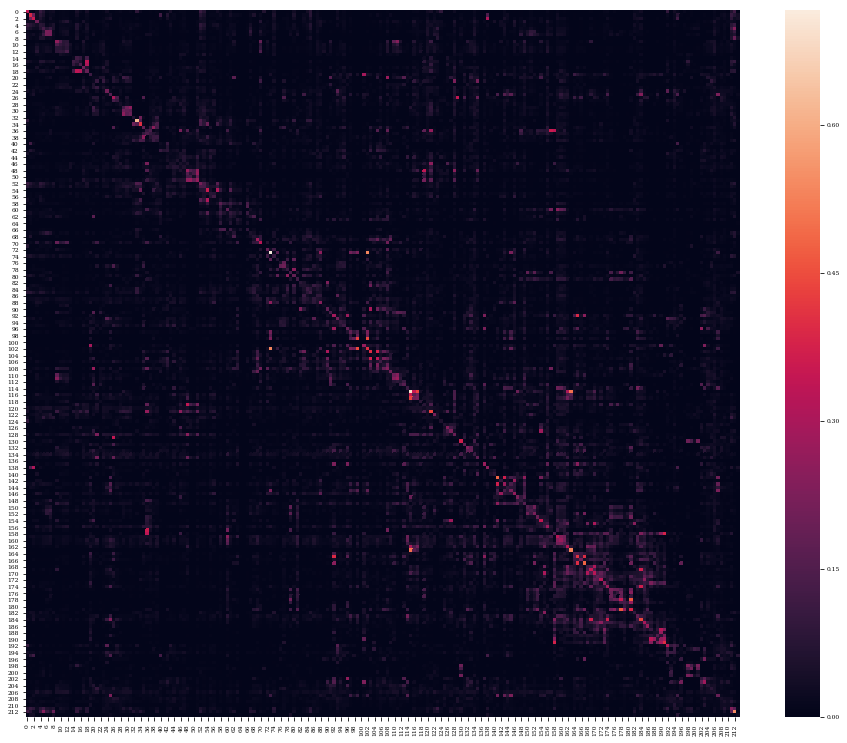

In [62]:
fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(final_matrix)
plt.savefig('m_genres6.png')

### Heatmap para la memoria: con etiquetas de los géneros musicales
### A. ANTES DE ORDENAR LOS GÉNEROS MUSICALES

In [63]:
final_matrix_not_sorted = compute_complete_matrix(m_perc, df_artists, list_tags_original)

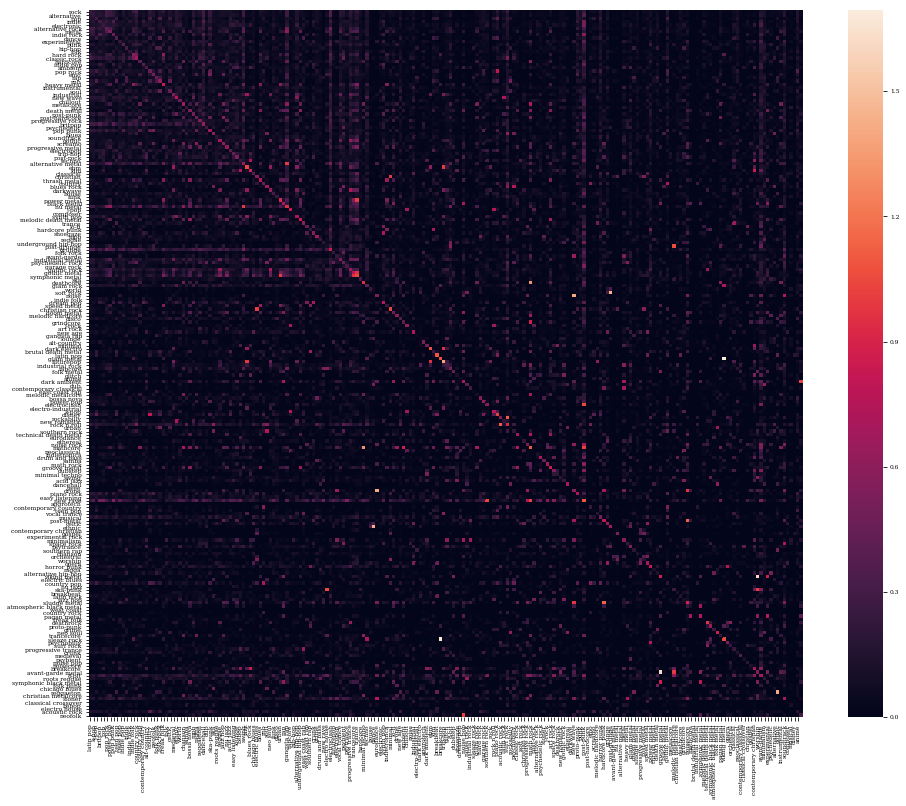

In [64]:
font = {'family' : 'serif',
        'size'   : 6}
plt.rc('font', **font)

fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(final_matrix_not_sorted, xticklabels=list_tags, yticklabels=list_tags_original)
plt.savefig('heatmap.png')

### B. DESPUÉS DE ORDENAR LOS GÉNEROS MUSICALES

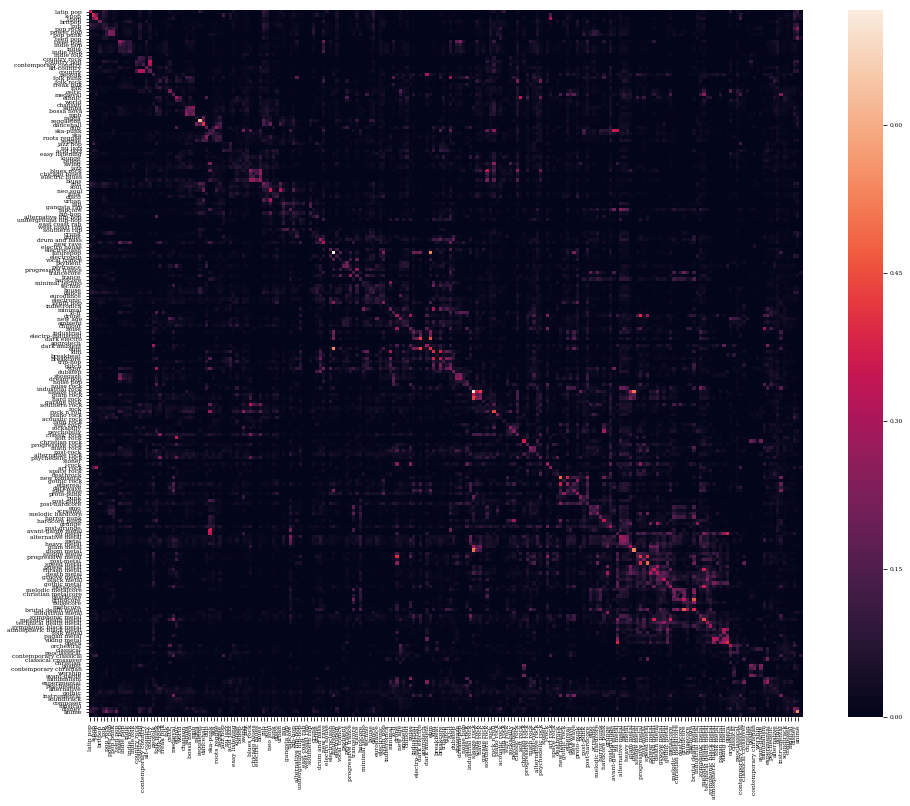

In [26]:
font = {'family' : 'serif',
        'size'   : 6}
plt.rc('font', **font)

fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(final_matrix, xticklabels=list_tags, yticklabels=list_tags)
plt.savefig('heatmap_sorted.png')

### Heatmap Heavy Metal

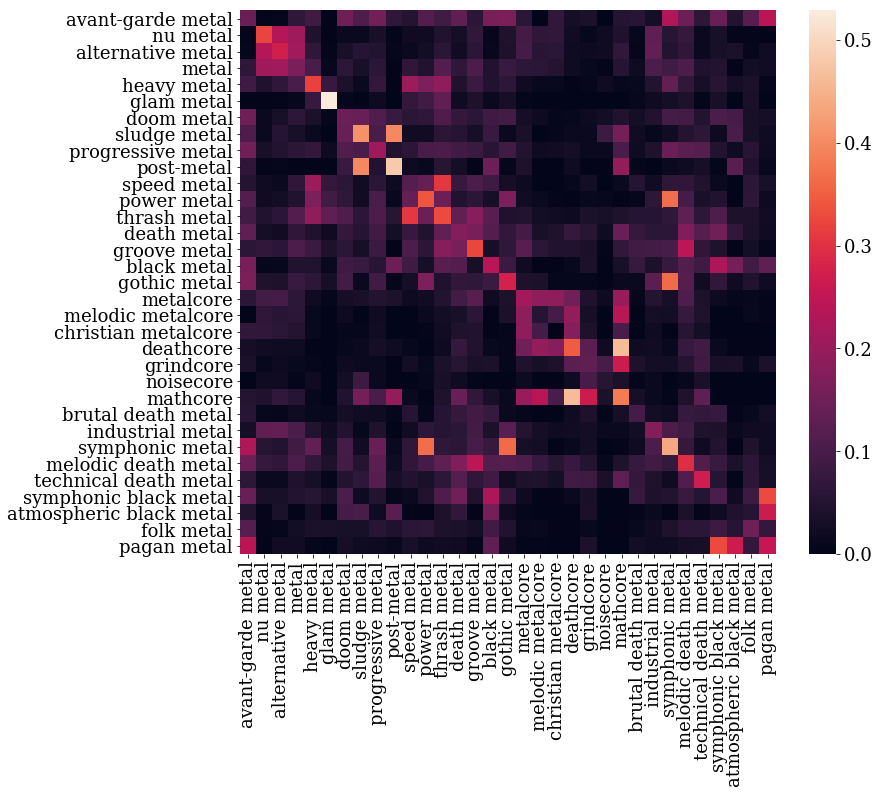

In [94]:
font = {'family' : 'serif',
        'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(12.0, 10.0))
ax = sns.heatmap(final_matrix[158:191, 158:191], xticklabels=list_tags[158:191], yticklabels=list_tags[158:191])
plt.savefig('m_genres_metal2.png')

### Heatmap Rock-Punk-Metal

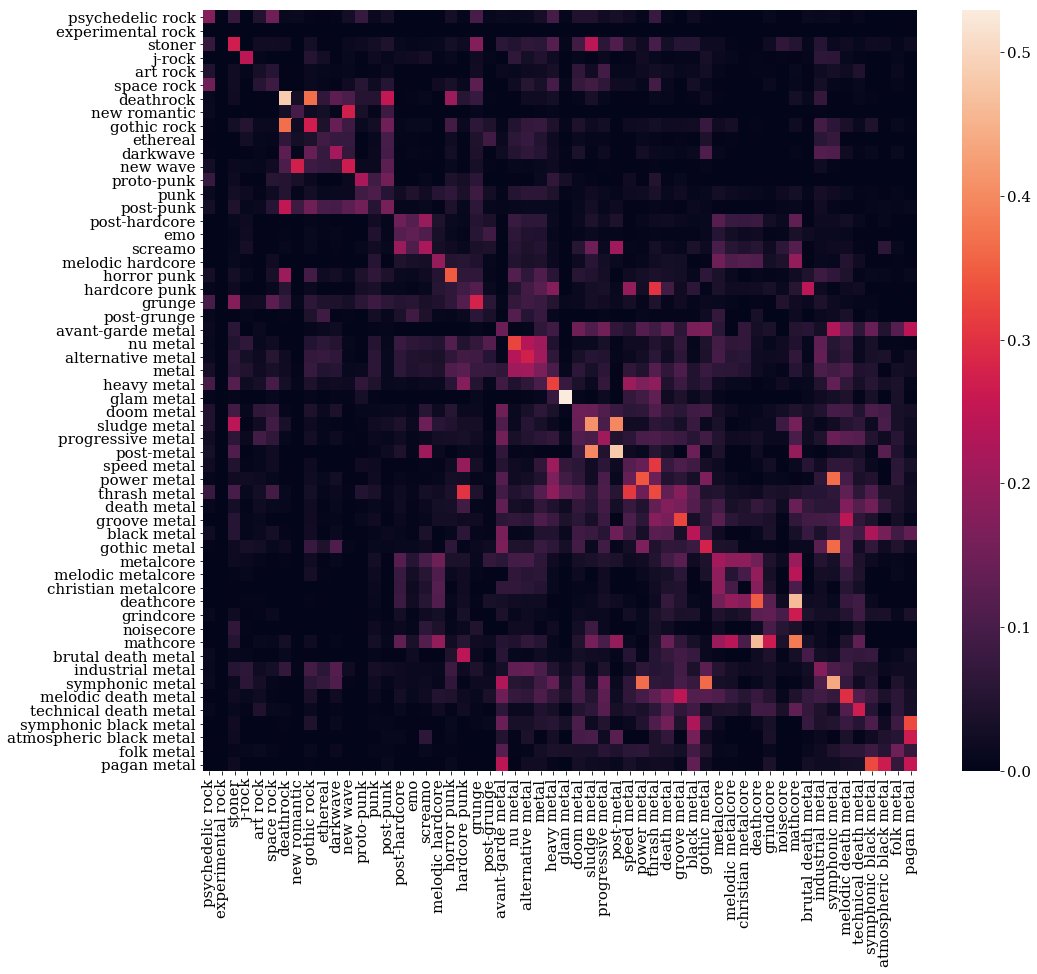

In [95]:
font = {'family' : 'serif',
        'size'   : 15}
plt.rc('font', **font)

fig = plt.figure(figsize=(16.0, 14.0))
ax = sns.heatmap(final_matrix[135:191, 135:191], xticklabels=list_tags[135:191], yticklabels=list_tags[135:191])
plt.savefig('m_genres_metalrock.png')

### Heatmap Electronica

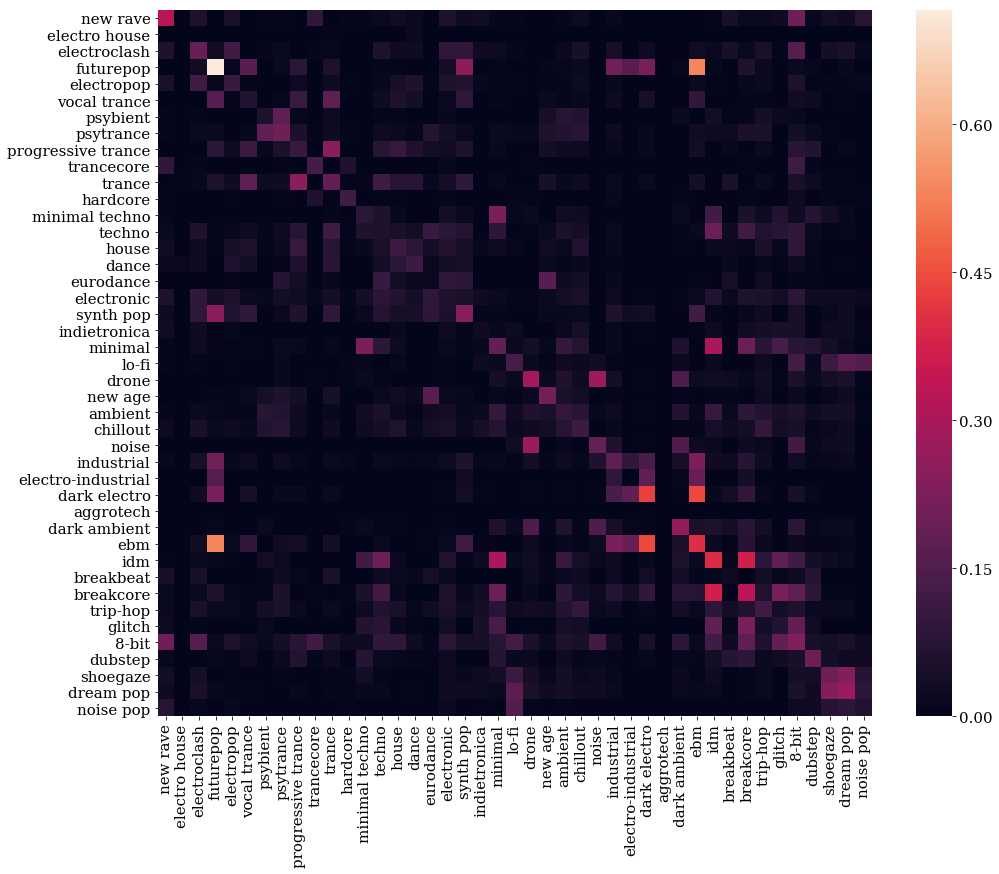

In [96]:
font = {'family' : 'serif',
        'size'   : 15}
plt.rc('font', **font)

fig = plt.figure(figsize=(16.0, 13.0))
ax = sns.heatmap(final_matrix[70:113, 70:113], xticklabels=list_tags[70:113], yticklabels=list_tags[70:113])
plt.savefig('m_genres_electro.png')

## 6. Power Law Distribution

Vamos a dibujar un diagrama para ver el grado de los géneros musicales (cuantos artistas hay de cada género musical) y ver si este sigue una distribucion "power law".

In [128]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from nxviz import MatrixPlot
import seaborn as sns
from matplotlib import pyplot as plt
import random

df_artists = pd.read_csv('artists-v2.dat', header=0, sep='\t', usecols=[0,2])
df_tags = pd.read_csv('artist_tags-v2.dat', header=0, sep= '\t')
df_users = pd.read_csv('user_artists.dat', header=0, sep='\t', usecols=[0,1])
df_artists = df_artists.join(df_tags.set_index('artistID'), on='artistID')

list_tags = pd.read_csv('tags-sorted.dat')
list_tags = list_tags.tag.tolist()

m = np.loadtxt('matrix.txt')
m_perc = np.loadtxt('matrix_percentage.txt')

In [8]:
G = generate_graph(m, df_artists, 0)

Obtenemos tres pares de listas, un par para cada uno de los géneros de los nodos del grafo (genero1, genero2 y genero3).

**Para cada atributo:**  
Primero obtenemos todas las apariciones de los géneros (valores que aparecen en cada uno de los atributos ['pop', 'pop', 'rock', 'alternative', 'pop', ...]) y los contamos de manera que obtenemos dos listas:
    - Una lista con los géneros. Ej. ['rock', 'pop', 'alternative']
    - Una lista con el número de apariciones (count). Ej. [10, 12, 8]

In [26]:
def get_genres_counts(graph):
    pl_genres = []
    pl_counts = []
    name_genre = ['genre1', 'genre2', 'genre3']
    for i in range (3):
        pl_genres_apparitions = []
        for k, v in graph.nodes(data=True):
            pl_genres_apparitions.append(v['attr_dict'][name_genre[i]])

        pl_g, pl_c = np.unique(pl_genres_apparitions, return_counts=True)
        pl_genres.append(pl_g)
        pl_counts.append(pl_c)
    
    return pl_genres, pl_counts

In [27]:
G_pl_genres, G_pl_counts = get_genres_counts(G)
print(G_pl_genres,'\n',G_pl_counts)

[array(['8-bit', 'acid jazz', 'acoustic rock', 'alt-country',
       'alternative', 'alternative metal', 'alternative rock', 'ambient',
       'anime', 'avant-garde', 'avant-garde metal', 'black metal',
       'blues', 'blues rock', 'bossa nova', 'breakcore', 'britpop',
       'brutal death metal', 'celtic', 'chanson', 'chillout', 'christian',
       'christian rock', 'classic rock', 'classical',
       'contemporary classical', 'country', 'dance', 'dancehall',
       'dark ambient', 'dark electro', 'darkwave', 'death metal',
       'deathcore', 'deathrock', 'disco', 'disney', 'doom metal',
       'dream pop', 'drone', 'drum and bass', 'dub', 'dubstep', 'ebm',
       'electroclash', 'electronic', 'electropop', 'emo', 'ethereal',
       'ethnic', 'eurodance', 'experimental', 'folk', 'folk metal',
       'folk punk', 'folk rock', 'funk', 'futurepop', 'garage rock',
       'glam metal', 'glam rock', 'glitch', 'gospel', 'gothic',
       'gothic metal', 'gothic rock', 'grime', 'grindcore',


In [28]:
index0 = np.where(G_pl_genres[0] == 'rock')
index1 = np.where(G_pl_genres[1] == 'rock')
index2 = np.where(G_pl_genres[2] == 'rock')

G_pl_counts[0][index0]+G_pl_counts[1][index1]*0.5+G_pl_counts[2][index2]*0.25

array([626.])

### Algoritmo final

Sumamos los tres arrays de counts que hemos obtenido (para los atributos genero1, genero2 y genero 3) recorriendo la lista "list_tags" que es la lista de etiquetas disponibles en nuestro grafo.

In [29]:
def get_complete_genres_counts(graph, tags):
    pl_genres, pl_counts = get_genres_counts(graph)
    pl_total_counts = np.zeros(len(tags))
    num_tag = 0
    weight = [1.0, 0.5, 0.25]
    for tag in tags:
        for i in range(3):
            index = np.where(pl_genres[i] == tag)[0]
            if len(index) > 0:
                pl_total_counts[num_tag] += pl_counts[i][index[0]]*weight[i]
        num_tag += 1

    pl_total_counts, pl_total_genres = zip(*sorted(zip(pl_total_counts, tags), reverse = True))
    
    return pl_total_genres, pl_total_counts

In [30]:
G_pl_total_genres, G_pl_total_counts = get_complete_genres_counts(G, list_tags)
print(G_pl_total_genres,'\n',G_pl_total_counts)

('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'pop punk', 'heavy metal', 'emo', 'pop rock', 'blues', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'screamo', 'shoegaze', 'gothic metal', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'darkwave', 'christian rock', 'folk metal', 'blues rock', 'symphonic metal', 'house', 'gothic', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'latin po

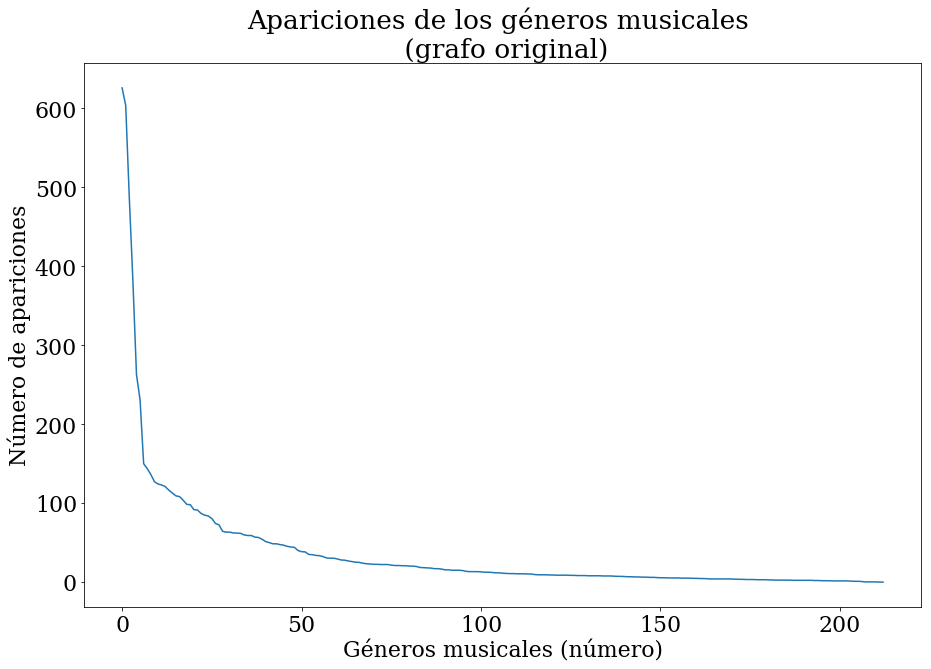

In [40]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))

ax.plot(G_pl_total_counts)
plt.title("Apariciones de los géneros musicales \n (grafo original)")
plt.ylabel("Número de apariciones")
plt.xlabel("Géneros musicales (número)")
plt.savefig("powerlaw.png")

## 7. Algoritmo de Axelrod 

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from nxviz import MatrixPlot
import seaborn as sns
from matplotlib import pyplot as plt
import random

df_artists = pd.read_csv('artists-v2.dat', header=0, sep='\t', usecols=[0,2])
df_tags = pd.read_csv('artist_tags-v2.dat', header=0, sep= '\t')
df_users = pd.read_csv('user_artists.dat', header=0, sep='\t', usecols=[0,1])
df_artists = df_artists.join(df_tags.set_index('artistID'), on='artistID')

list_tags = pd.read_csv('tags-sorted.dat')
list_tags = list_tags.tag.tolist()

m = np.loadtxt('matrix.txt')
m_perc = np.loadtxt('matrix_percentage.txt')

In [3]:
G = generate_graph(m, df_artists, 0)

In [4]:
nodes = list(G.nodes())

In [5]:
active_agent = random.choice(nodes)
passive_agent =  random.choice(list(G.neighbors(active_agent)))

In [6]:
sorted(G.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0][2]['weight']

436.0

In [7]:
G.edges['lady gaga', 'britney spears']['weight']

436.0

In [8]:
print("Active agent: '"+active_agent+"', Passive agent: '"+passive_agent+"'")

Active agent: 'jay vaquer', Passive agent: 'carrie underwood'


In [9]:
print(G.node[active_agent])
print(G.node[passive_agent])

{'attr_dict': {'genre1': 'alternative', 'genre2': 'pop rock', 'genre3': 'rock', 'freq': 14}}
{'attr_dict': {'genre1': 'country', 'genre2': 'pop', 'genre3': 'country pop', 'freq': 76}}


Escoger cualquiera de los tres generos con la misma probabilidad??

In [90]:
genres = ['genre1', 'genre2', 'genre3']
num_active_genre = genres[random.randint(0,2)]

active_genre = G.node[active_agent]['attr_dict'][num_active_genre]
active_genre

'hip-hop'

In [91]:
passive_genres = list(G.node[passive_agent]['attr_dict'].values())[0:3]
active_genres = list(G.node[active_agent]['attr_dict'].values())[0:3]
print(passive_genres, active_genres)
set(['trip-hop', 'shoegaze', 'chillout']) == set (['shoegaze','trip-hop', 'chillout'])

['pop', 'britpop', 'electronic'] ['pop', 'rnb', 'hip-hop']


True

In [92]:
num_passive_genre = genres[random.randint(0,2)]
G.node[passive_agent]['attr_dict'][num_passive_genre] = active_genre
print(G.node[passive_agent])

{'attr_dict': {'genre1': 'pop', 'genre2': 'britpop', 'genre3': 'hip-hop', 'freq': 91}}


In [93]:
G.node[active_agent]

{'attr_dict': {'genre1': 'pop',
  'genre2': 'rnb',
  'genre3': 'hip-hop',
  'freq': 96}}

In [94]:
sorted(G.edges('lady gaga',data=True),key= lambda x: x[2]['weight'],reverse=True)


[('lady gaga', 'britney spears', {'weight': 436.0}),
 ('lady gaga', 'rihanna', {'weight': 414.0}),
 ('lady gaga', 'katy perry', {'weight': 396.0}),
 ('lady gaga', 'christina aguilera', {'weight': 345.0}),
 ('lady gaga', 'beyoncé', {'weight': 338.0}),
 ('lady gaga', 'madonna', {'weight': 310.0}),
 ('lady gaga', 'ke$ha', {'weight': 310.0}),
 ('lady gaga', 'avril lavigne', {'weight': 299.0}),
 ('lady gaga', 'shakira', {'weight': 262.0}),
 ('lady gaga', 'black eyed peas', {'weight': 259.0}),
 ('lady gaga', 'p!nk', {'weight': 248.0}),
 ('lady gaga', 'miley cyrus', {'weight': 243.0}),
 ('lady gaga', 'kylie minogue', {'weight': 241.0}),
 ('lady gaga', 'paramore', {'weight': 222.0}),
 ('lady gaga', 'kelly clarkson', {'weight': 205.0}),
 ('lady gaga', 'the pussycat dolls', {'weight': 201.0}),
 ('lady gaga', 'glee cast', {'weight': 198.0}),
 ('lady gaga', 'mariah carey', {'weight': 194.0}),
 ('lady gaga', 'taylor swift', {'weight': 190.0}),
 ('lady gaga', 'jennifer lopez', {'weight': 181.0}),
 (

In [95]:
G.node['lady gaga']

{'attr_dict': {'genre1': 'pop',
  'genre2': 'dance',
  'genre3': 'electronic',
  'freq': 611}}

In [96]:
weight_node = sorted(G.edges('lady gaga',data=True),key= lambda x: x[2]['weight'],reverse=True)[0][2]['weight']
print(weight_node)

436.0


In [97]:
num_nodes = G.number_of_nodes()
weight_nodes = {}
for name_artist, inner_d in G.nodes(data=True):
    weight_nodes[name_artist] = sorted(G.edges(name_artist,data=True),key= lambda x: x[2]['weight'],reverse=True)[0][2]['weight']

In [98]:
print(weight_nodes)

{'lady gaga': 436.0, 'britney spears': 436.0, 'rihanna': 414.0, 'the beatles': 193.0, 'katy perry': 396.0, 'madonna': 310.0, 'avril lavigne': 299.0, 'christina aguilera': 360.0, 'muse': 171.0, 'paramore': 222.0, 'beyoncé': 348.0, 'radiohead': 193.0, 'coldplay': 160.0, 'ke$ha': 313.0, 'shakira': 270.0, 'p!nk': 248.0, 'the killers': 156.0, 'black eyed peas': 259.0, 'kylie minogue': 249.0, 'miley cyrus': 255.0, 'depeche mode': 117.0, 'linkin park': 121.0, 'michael jackson': 153.0, 'kelly clarkson': 220.0, 'nirvana': 119.0, 'pink floyd': 156.0, 'glee cast': 198.0, 'arctic monkeys': 140.0, 'taylor swift': 198.0, 'lily allen': 171.0, 'placebo': 127.0, 'mariah carey': 208.0, 'green day': 110.0, 'kings of leon': 114.0, 'the pussycat dolls': 215.0, 'the cure': 117.0, 'evanescence': 124.0, 'metallica': 98.0, 'red hot chili peppers': 102.0, '30 seconds to mars': 120.0, 'oasis': 120.0, 'jennifer lopez': 194.0, 'queen': 109.0, 'eminem': 116.0, 'david bowie': 113.0, 'led zeppelin': 125.0, 'amy wineh

### Algoritmo Final

In [10]:
import random 

def axelrod (Graph, value):
    
    graph = copy_graph(Graph)
    nodes = list(graph.nodes())
    name_genres = ['genre1', 'genre2', 'genre3']
    weight_actives, artist_actives = calculate_active_weights(graph)
    iteration = 0
    count = 0
    
    #Si pasa mucho rato (seguido) sin que ningún género cambie damos por finalizado el proceso
    for not_change in range (value):

        if iteration%1000000 == 0:
            print(iteration)
            print(not_change)
        
        #Escogemos los dos nodos (activo y pasivo) de forma totalmente aleatoria
        active_agent = get_random_active(weight_actives, artist_actives)
        passive_agent = get_random_passive(graph, active_agent)
            
        #Escogemos de cada uno un género

        all_passive_genres = list(graph.node[passive_agent]['attr_dict'].values())[0:3]
        passive_genres = list(filter(lambda x: x==x, all_passive_genres))
        all_active_genres = list(graph.node[active_agent]['attr_dict'].values())[0:3]
        active_genres = list(filter(lambda x: x==x, all_active_genres))
        
        missing_actives = list(set(active_genres).difference(passive_genres))

        if (len(missing_actives) > 0):
            
            num_common_genres = len(set(active_genres).intersection(set(passive_genres)))
            threshold = 1 - num_common_genres/3 #(numero de tags comunes)
            prob = random.uniform(0,1)

            
            #Con probabilidad X cambiamos el género del nodo pasivo por el del nodo activo
            if prob > threshold:
                not_change = 0
                count += 1
                active_genre = missing_actives[0]
                num_passive_genre = 2
                while all_passive_genres[num_passive_genre] in active_genres:
                    num_passive_genre -=1   

                graph.node[passive_agent]['attr_dict'][name_genres[num_passive_genre]] = active_genre
                
        iteration+=1
        
    print(count)
    return graph


def copy_graph(graph):
    copy_graph = nx.Graph()
    nodes = list(graph.nodes(data=True))

    for node in nodes:
        name = node[0]
        genre1 = node[1]['attr_dict']['genre1']
        genre2 = node[1]['attr_dict']['genre2']
        genre3 = node[1]['attr_dict']['genre3']
        freq = node[1]['attr_dict']['freq']
        
        copy_graph.add_node(name, attr_dict = {'genre1': genre1,
                                                     'genre2': genre2,
                                                     'genre3': genre3, 
                                                     'freq': freq})
        
    edges = G.edges(data=True)
    for edge in edges:
        copy_graph.add_edge(edge[0], edge[1], weight = edge[2]['weight'])
                 
    return copy_graph

def get_random_active(freq, artists):    
    return get_random_node(freq, artists)

def get_random_passive(graph, active_node):   
    dict_G = graph.neighbors(active_node)
    artists = []
    freq = []
    node = None
    
    edges = sorted(graph.edges(active_node, data=True),key= lambda x: x[2]['weight'],reverse=True)

    for active, passive, weight in edges:
        artists.append(passive)
        freq.append(weight['weight'])
        
    return get_random_node(freq, artists)

def get_random_node(freq, artists):   
    freq, artists = zip(*sorted(zip(freq, artists), reverse = True))
    total_freq = sum(freq)
    rand_int = random.randint(0,total_freq-1)
    i=0
    counter = 0
    for value in freq:
        counter += value
        if counter > rand_int:
            return artists[i]
        i += 1       

#Para elegir el nodo activo tenemos en cuenta los pesos de las aristas del nodo.      
def calculate_active_weights(graph):
    freq = []
    artists = []
    for node in graph.nodes():
        edges = graph.edges(node, data=True)
        weight_node = 0
        for active, passive, weight in edges:
            weight_node += weight['weight']
        artists.append(node)
        freq.append(weight_node)
        
    return freq, artists

In [11]:
G.node['britney spears']

{'attr_dict': {'genre1': 'pop', 'genre2': 'dance', 'genre3': nan, 'freq': 522}}

In [12]:
G_axelrod = axelrod(G,200)

0
0
42


In [13]:
G_axelrod.number_of_nodes()

4562

In [14]:
G_axelrod.node['britney spears']

{'attr_dict': {'genre1': 'pop', 'genre2': 'dance', 'genre3': nan, 'freq': 522}}

In [15]:
G_axelrod.node['arctic monkeys']

{'attr_dict': {'genre1': 'indie rock',
  'genre2': 'indie',
  'genre3': 'rock',
  'freq': 248}}

In [16]:
G_axelrod.node['my chemical romance']

{'attr_dict': {'genre1': 'rock',
  'genre2': 'emo',
  'genre3': 'pop rock',
  'freq': 157}}

In [17]:
G_axelrod.node['black eyed peas']

{'attr_dict': {'genre1': 'hip-hop',
  'genre2': 'pop',
  'genre3': 'rnb',
  'freq': 304}}

In [18]:
G_axelrod.node['rammstein']

{'attr_dict': {'genre1': 'industrial metal',
  'genre2': 'metal',
  'genre3': 'industrial',
  'freq': 140}}

In [19]:
G_axelrod.node['justin bieber']

{'attr_dict': {'genre1': 'pop',
  'genre2': 'black metal',
  'genre3': 'rnb',
  'freq': 100}}

In [20]:
G_axelrod.node['slipknot']

{'attr_dict': {'genre1': 'nu metal',
  'genre2': 'metal',
  'genre3': 'heavy metal',
  'freq': 112}}

In [21]:
G_axelrod.node['david guetta']

{'attr_dict': {'genre1': 'house',
  'genre2': 'dance',
  'genre3': 'electronic',
  'freq': 155}}

In [22]:
G_axelrod.node['lady gaga']

{'attr_dict': {'genre1': 'pop',
  'genre2': 'dance',
  'genre3': 'electronic',
  'freq': 611}}

In [23]:
G_axelrod.node['burzum']

{'attr_dict': {'genre1': 'black metal',
  'genre2': 'dark ambient',
  'genre3': 'ambient',
  'freq': 19}}

In [24]:
G_axelrod.node['red hot chili peppers']

{'attr_dict': {'genre1': 'rock',
  'genre2': 'alternative rock',
  'genre3': 'alternative',
  'freq': 222}}

In [32]:
G_axelrod_pl_total_genres, G_axelrod_pl_total_counts = get_complete_genres_counts(G_axelrod, list_tags)
print(G_axelrod_pl_total_genres,'\n',G_axelrod_pl_total_counts)

('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'heavy metal', 'pop punk', 'emo', 'pop rock', 'blues', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'shoegaze', 'screamo', 'gothic metal', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'blues rock', 'darkwave', 'christian rock', 'folk metal', 'symphonic metal', 'house', 'gothic', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'latin po

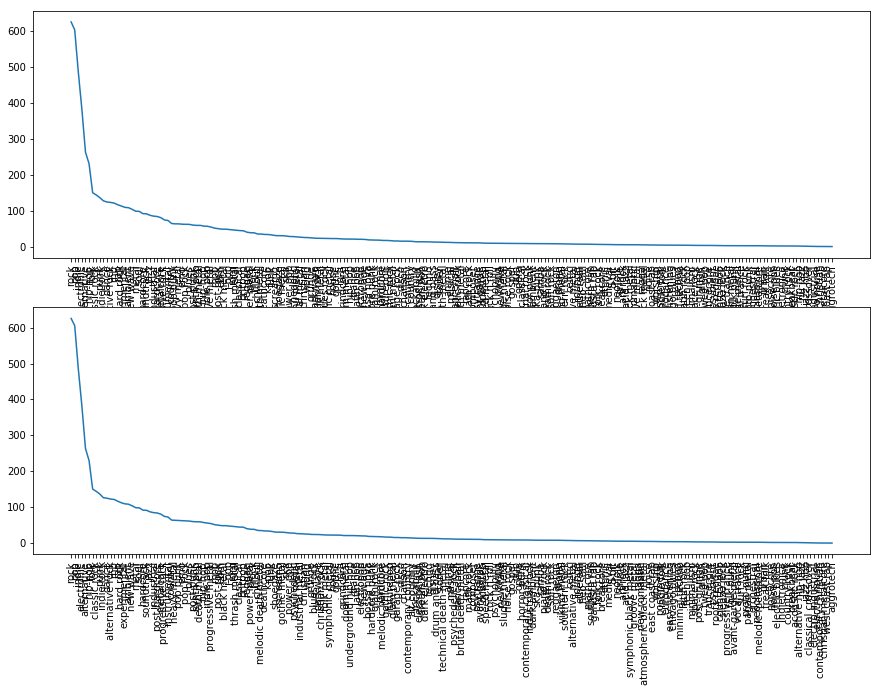

In [64]:
plt.figure(figsize=(15,10))
plt.figure(1)
plt.subplot(211)
plt.xticks(rotation='vertical')
plt.plot(G_pl_total_genres, G_pl_total_counts)

plt.subplot(212)
plt.xticks(rotation='vertical')
plt.plot(G_axelrod_pl_total_genres, G_axelrod_pl_total_counts)

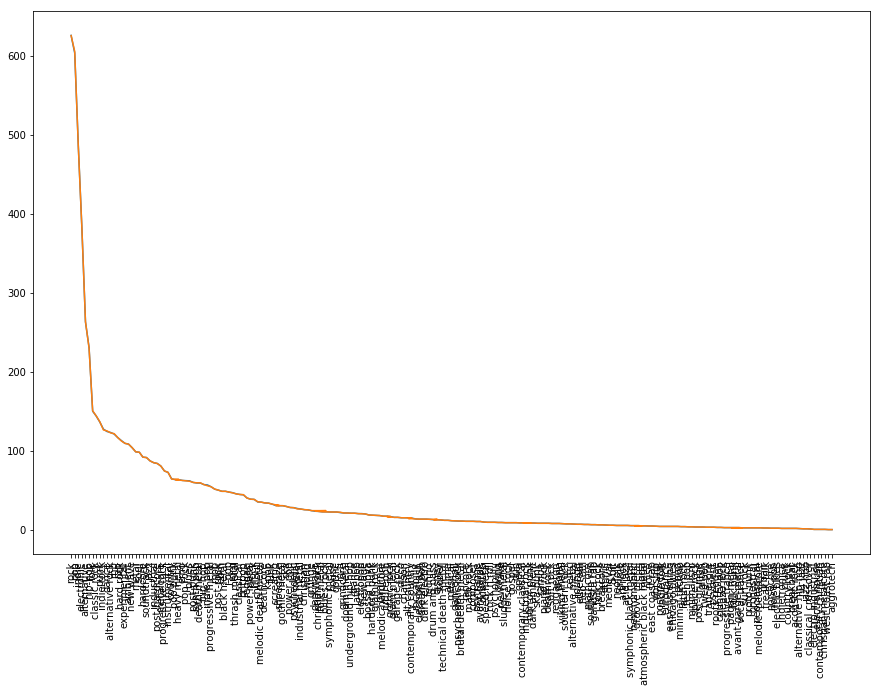

In [65]:
plt.figure(figsize=(15,10))
plt.plot(G_pl_total_genres, G_pl_total_counts)
plt.plot(G_axelrod_pl_total_genres, G_axelrod_pl_total_counts)
plt.xticks(rotation='vertical')
plt.savefig(".jpg")

## 8. GET TOP TAGS

Visualización de las subidas y bajadas de los géneros musicales

In [1]:
def get_top_tags(initial_positions, final_positions, initial_counts, final_counts, tags, opt_print=False):
    tag_positions = np.empty(len(tags), dtype=[('tag', 'S20'), ('init', int), ('final', int), ('diff',int), ('init_count', int), ('final_count', int), ('diff_count', int)])
    for i in range (len(tags)):
        tag = tags[i]
        initial_idx = initial_positions.index(tag) 
        final_idx = final_positions.index(tag) 
        init_count = initial_counts[initial_idx]
        final_count = final_counts[final_idx]
        tag_positions[i][0] = tag
        tag_positions[i][1] = initial_idx
        tag_positions[i][2] = final_idx
        tag_positions[i][3] = initial_idx - final_idx
        tag_positions[i][4] = init_count
        tag_positions[i][5] = final_count
        tag_positions[i][6] = final_count - init_count

    tag_positions.sort(order='final')
    
    if opt_print:
        for tag, ini, fin, dif, ini_c, fin_c, dif_c in tag_positions:
            i+=1
            sign = ''
            sign2 = ''
            
            if dif > 0:
                sign = '+'
            if dif_c > 0:
                sign2 = '+'
            print(str(fin)+'.',tag.decode('utf-8'),'('+str(ini)+', '+sign+str(dif)+', '+str(ini_c)+', '+str(fin_c)+', ',sign2+str(dif_c)+')')  
        
    return tag_positions

def get_positions(tag_positions):
    list_positions = []
    i=0
    for tag, ini, fin, dif, ini_c, fin_c, dif_c in tag_positions:
        list_positions.append(dif)
    list_positions.sort(reverse = True)
    
    return list_positions

In [7]:
get_top_tags(G_pl_total_genres,  G_axelrod_pl_total_genres, G_pl_total_counts, G_axelrod_pl_total_counts, list_tags, True)

0. rock (0, 0, 626, 625,  0)
1. pop (1, 0, 603, 604,  0)
2. indie (2, 0, 486, 486,  0)
3. electronic (3, 0, 382, 382,  0)
4. alternative (4, 0, 263, 265,  +2)
5. hip-hop (5, 0, 230, 230,  0)
6. folk (6, 0, 150, 150,  0)
7. classic rock (7, 0, 143, 144,  0)
8. punk (8, 0, 136, 137,  +1)
9. indie rock (9, 0, 127, 129,  +1)
10. dance (10, 0, 124, 124,  0)
11. alternative rock (11, 0, 123, 124,  +1)
12. rnb (12, 0, 121, 121,  0)
13. rap (13, 0, 116, 116,  0)
14. hard rock (14, 0, 112, 112,  0)
15. experimental (15, 0, 109, 109,  0)
16. ambient (16, 0, 108, 108,  0)
17. new wave (17, 0, 103, 103,  0)
18. metal (18, 0, 98, 99,  0)
19. soul (19, 0, 98, 98,  0)
20. hardcore (20, 0, 91, 91,  0)
21. soundtrack (21, 0, 91, 90,  0)
22. jazz (22, 0, 87, 87,  0)
23. industrial (23, 0, 84, 84,  0)
24. post-hardcore (24, 0, 83, 83,  0)
25. metalcore (25, 0, 80, 80,  0)
26. progressive rock (26, 0, 74, 74,  0)
27. instrumental (27, 0, 72, 72,  0)
28. country (28, 0, 64, 64,  0)
29. pop punk (29, 0, 63,

array([(b'rock',   0,   0,  0, 626, 625,  0),
       (b'pop',   1,   1,  0, 603, 604,  0),
       (b'indie',   2,   2,  0, 486, 486,  0),
       (b'electronic',   3,   3,  0, 382, 382,  0),
       (b'alternative',   4,   4,  0, 263, 265,  2),
       (b'hip-hop',   5,   5,  0, 230, 230,  0),
       (b'folk',   6,   6,  0, 150, 150,  0),
       (b'classic rock',   7,   7,  0, 143, 144,  0),
       (b'punk',   8,   8,  0, 136, 137,  1),
       (b'indie rock',   9,   9,  0, 127, 129,  1),
       (b'dance',  10,  10,  0, 124, 124,  0),
       (b'alternative rock',  11,  11,  0, 123, 124,  1),
       (b'rnb',  12,  12,  0, 121, 121,  0),
       (b'rap',  13,  13,  0, 116, 116,  0),
       (b'hard rock',  14,  14,  0, 112, 112,  0),
       (b'experimental',  15,  15,  0, 109, 109,  0),
       (b'ambient',  16,  16,  0, 108, 108,  0),
       (b'new wave',  17,  17,  0, 103, 103,  0),
       (b'metal',  18,  18,  0,  98,  99,  0),
       (b'soul',  19,  19,  0,  98,  98,  0),
       (b'hardcore

## 9. PRUEBAS

## Prueba A

In [139]:
#G = generate_graph(m, df_artists, 0)
#G_axelrod1 = axelrod(G,200)
#G_axelrod2 = axelrod(G,2000)
#G_axelrod3 = axelrod(G,20000)
#G_axelrod4 = axelrod(G,200000)

In [ ]:
#G_pl_total_genres, G_pl_total_counts = get_complete_genres_counts(G, list_tags)
#G_axelrod1_pl_total_genres, G_axelrod1_pl_total_counts = get_complete_genres_counts(G_axelrod1, list_tags)
#G_axelrod2_pl_total_genres, G_axelrod2_pl_total_counts = get_complete_genres_counts(G_axelrod2, list_tags)
#G_axelrod3_pl_total_genres, G_axelrod3_pl_total_counts = get_complete_genres_counts(G_axelrod3, list_tags)
#G_axelrod4_pl_total_genres, G_axelrod4_pl_total_counts = get_complete_genres_counts(G_axelrod4, list_tags)

In [8]:
num_de_cambios = []
G_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'pop punk', 'heavy metal', 'emo', 'pop rock', 'blues', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'screamo', 'shoegaze', 'gothic metal', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'darkwave', 'christian rock', 'folk metal', 'blues rock', 'symphonic metal', 'house', 'gothic', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'latin pop', 'electropop', 'new age', 'bossa nova', 'hardcore punk', 'glam rock', 'minimal', 'melodic hardcore', 'futurepop', 'gothic rock', 'glam metal', 'garage rock', 'disco', 'chanson', 'alt-country', 'contemporary country', 'rockabilly', 'electroclash', 'dream pop', 'dark electro', 'techno', 'drum and bass', 'disney', 'stoner', 'technical death metal', 'anime', 'musical', 'dancehall', 'psychedelic rock', 'brutal death metal', 'rapcore', 'math rock', 'composer', 'psytrance', 'avant-garde', 'dubstep', 'speed metal', 'rock n roll', 'psychobilly', 'swing', 'new rave', 'sludge metal', 'noise rock', 'gospel', 'dub', 'opera', 'contemporary classical', 'industrial rock', 'horror punk', 'dark ambient', 'ska-punk', 'samba', 'piano rock', 'deathrock', 'soft rock', 'reggaeton', 'drone', 'viking metal', 'southern rock', 'celtic', 'alternative metal', 'lounge', 'ethereal', 'neo soul', 'mathcore', 'southern rap', 'gangsta rap', 'folk rock', 'breakcore', 'ethnic', 'medieval', '8-bit', 'neofolk', 'grime', 'art rock', 'acid jazz', 'symphonic black metal', 'new romantic', 'groove metal', 'ragga', 'atmospheric black metal', 'noise', 'east coast rap', 'worship', 'post-metal', 'indie folk', 'eurodance', 'easy listening', 'chicago blues', 'bebop', 'minimal techno', 'latin rock', 'teen pop', 'minimalism', 'space rock', 'post-grunge', 'glitch', 'twee pop', 'trancecore', 'psybient', 'roots reggae', 'country pop', 'sleaze rock', 'progressive trance', 'pagan metal', 'folk punk', 'avant-garde metal', 'vocal trance', 'surf rock', 'proto-punk', 'orchestral', 'neoclassical', 'melodic metalcore', 'urban', 'freak folk', 'noisecore', 'noise pop', 'electric blues', 'indietronica', 'crunk', 'country rock', 'breakbeat', 'acoustic rock', 'alternative hip-hop', 'nu jazz', 'jazz hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech')
G_pl_total_counts = (626.0, 603.75, 486.75, 382.0, 263.0, 230.75, 150.0, 143.75, 136.25, 127.25, 124.25, 123.0, 121.0, 116.5, 112.75, 109.25, 108.25, 103.75, 98.5, 98.0, 91.75, 91.25, 87.0, 84.75, 83.75, 80.5, 74.25, 72.5, 64.25, 63.25, 63.25, 62.25, 62.0, 61.75, 59.75, 59.0, 59.0, 57.0, 56.5, 54.25, 51.25, 50.0, 48.5, 48.5, 47.5, 46.75, 45.25, 44.5, 44.0, 40.0, 38.5, 38.25, 35.0, 34.75, 33.75, 33.5, 32.25, 30.5, 30.25, 30.25, 29.25, 28.0, 27.75, 26.75, 26.0, 25.25, 25.0, 24.0, 23.25, 23.0, 22.5, 22.5, 22.25, 22.25, 22.25, 21.5, 21.0, 21.0, 20.75, 20.75, 20.25, 20.25, 19.75, 18.5, 18.25, 18.0, 17.75, 17.0, 17.0, 16.5, 15.5, 15.5, 15.0, 15.0, 15.0, 14.5, 13.5, 13.25, 13.25, 13.25, 13.0, 12.5, 12.5, 12.25, 11.75, 11.75, 11.25, 11.0, 10.75, 10.75, 10.5, 10.5, 10.5, 10.25, 10.25, 9.5, 9.25, 9.25, 9.25, 9.0, 9.0, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 7.75, 7.75, 7.75, 7.5, 7.25, 7.25, 7.0, 6.75, 6.75, 6.5, 6.5, 6.25, 6.25, 6.0, 6.0, 5.75, 5.5, 5.5, 5.25, 5.25, 5.25, 5.25, 5.0, 5.0, 5.0, 4.75, 4.75, 4.5, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 3.0, 2.75, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.5, 1.25, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0)
G_axelrod1_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'pop punk', 'heavy metal', 'emo', 'blues', 'pop rock', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'shoegaze', 'gothic metal', 'screamo', 'ska', 'psychedelic', 'power pop', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'darkwave', 'christian rock', 'gothic', 'folk metal', 'blues rock', 'symphonic metal', 'house', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'latin pop', 'electropop', 'new age', 'hardcore punk', 'bossa nova', 'minimal', 'glam rock', 'futurepop', 'melodic hardcore', 'gothic rock', 'glam metal', 'garage rock', 'disco', 'chanson', 'alt-country', 'contemporary country', 'rockabilly', 'dream pop', 'dark electro', 'techno', 'electroclash', 'drum and bass', 'stoner', 'disney', 'technical death metal', 'anime', 'musical', 'dancehall', 'psychedelic rock', 'brutal death metal', 'rapcore', 'math rock', 'composer', 'psytrance', 'avant-garde', 'dubstep', 'speed metal', 'psychobilly', 'swing', 'sludge metal', 'noise rock', 'new rave', 'gospel', 'dub', 'opera', 'contemporary classical', 'rock n roll', 'industrial rock', 'horror punk', 'dark ambient', 'ska-punk', 'samba', 'piano rock', 'deathrock', 'soft rock', 'reggaeton', 'drone', 'viking metal', 'southern rock', 'celtic', 'alternative metal', 'lounge', 'ethereal', 'neo soul', 'mathcore', 'southern rap', 'gangsta rap', 'folk rock', 'breakcore', 'ethnic', 'medieval', '8-bit', 'neofolk', 'grime', 'acid jazz', 'new romantic', 'groove metal', 'ragga', 'atmospheric black metal', 'art rock', 'symphonic black metal', 'noise', 'east coast rap', 'worship', 'post-metal', 'indie folk', 'easy listening', 'chicago blues', 'bebop', 'minimal techno', 'latin rock', 'eurodance', 'teen pop', 'minimalism', 'space rock', 'post-grunge', 'glitch', 'twee pop', 'trancecore', 'psybient', 'roots reggae', 'country pop', 'sleaze rock', 'progressive trance', 'pagan metal', 'folk punk', 'avant-garde metal', 'acoustic rock', 'vocal trance', 'surf rock', 'proto-punk', 'orchestral', 'neoclassical', 'melodic metalcore', 'urban', 'freak folk', 'noisecore', 'noise pop', 'electric blues', 'indietronica', 'crunk', 'country rock', 'breakbeat', 'alternative hip-hop', 'nu jazz', 'jazz hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech') 
G_axelrod1_pl_total_counts = (625.75, 604.0, 486.5, 382.75, 265.25, 230.25, 150.0, 144.5, 137.25, 129.0, 124.0, 124.0, 121.25, 116.5, 112.5, 109.0, 108.25, 103.75, 99.0, 98.25, 91.75, 90.75, 87.0, 84.75, 83.75, 80.5, 74.25, 72.5, 64.25, 63.25, 63.0, 62.25, 61.75, 61.5, 60.0, 59.25, 59.0, 57.25, 56.5, 54.25, 51.25, 50.0, 48.5, 48.0, 47.5, 46.75, 45.25, 44.5, 41.75, 40.0, 38.5, 38.25, 35.0, 34.75, 33.75, 33.5, 32.25, 30.25, 30.25, 30.0, 29.25, 28.0, 28.0, 26.25, 26.0, 25.25, 25.0, 24.0, 23.25, 22.75, 22.5, 22.5, 22.5, 22.25, 22.25, 21.5, 21.0, 21.0, 20.75, 20.75, 20.25, 20.0, 19.75, 18.75, 18.5, 17.75, 17.5, 17.0, 16.5, 16.5, 15.5, 15.5, 15.0, 15.0, 15.0, 14.5, 13.5, 13.25, 13.25, 13.0, 12.75, 12.5, 12.25, 12.25, 11.75, 11.75, 11.25, 11.0, 10.75, 10.75, 10.5, 10.5, 10.5, 10.25, 10.25, 9.5, 9.25, 9.25, 9.0, 8.75, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 7.75, 7.75, 7.75, 7.5, 7.25, 7.25, 7.0, 6.75, 6.75, 6.5, 6.5, 6.25, 6.25, 6.0, 6.0, 5.75, 5.5, 5.5, 5.25, 5.25, 5.25, 5.0, 5.0, 4.75, 4.75, 4.75, 4.5, 4.5, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 3.0, 2.75, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.25, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0)
G_axelrod2_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'alternative rock', 'indie rock', 'rnb', 'dance', 'rap', 'hard rock', 'ambient', 'experimental', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'heavy metal', 'blues', 'emo', 'pop punk', 'pop rock', 'post-punk', 'death metal', 'trip-hop', 'synth pop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'melodic death metal', 'chillout', 'deathcore', 'k-pop', 'funk', 'screamo', 'shoegaze', 'gothic metal', 'ska', 'power pop', 'nu metal', 'psychedelic', 'industrial metal', 'christian', 'world', 'darkwave', 'christian rock', 'house', 'gothic', 'folk metal', 'blues rock', 'symphonic metal', 'grunge', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'electropop', 'new age', 'latin pop', 'minimal', 'hardcore punk', 'bossa nova', 'melodic hardcore', 'gothic rock', 'glam rock', 'futurepop', 'glam metal', 'disco', 'chanson', 'contemporary country', 'garage rock', 'dream pop', 'rockabilly', 'alt-country', 'techno', 'electroclash', 'dark electro', 'stoner', 'drum and bass', 'disney', 'technical death metal', 'anime', 'musical', 'psychedelic rock', 'dancehall', 'composer', 'brutal death metal', 'psytrance', 'avant-garde', 'rapcore', 'math rock', 'dubstep', 'speed metal', 'rock n roll', 'psychobilly', 'swing', 'sludge metal', 'noise rock', 'new rave', 'gospel', 'dub', 'horror punk', 'deathrock', 'soft rock', 'opera', 'contemporary classical', 'ska-punk', 'samba', 'industrial rock', 'drone', 'dark ambient', 'reggaeton', 'viking metal', 'celtic', 'southern rap', 'alternative metal', 'southern rock', 'piano rock', 'ethereal', 'mathcore', 'lounge', 'neo soul', 'folk rock', 'gangsta rap', 'breakcore', 'ethnic', '8-bit', 'medieval', 'neofolk', 'grime', 'art rock', 'acid jazz', 'symphonic black metal', 'indie folk', 'groove metal', 'ragga', 'new romantic', 'atmospheric black metal', 'noise', 'worship', 'post-metal', 'east coast rap', 'chicago blues', 'bebop', 'minimal techno', 'eurodance', 'easy listening', 'trancecore', 'teen pop', 'minimalism', 'space rock', 'post-grunge', 'latin rock', 'glitch', 'twee pop', 'psybient', 'roots reggae', 'proto-punk', 'country pop', 'progressive trance', 'pagan metal', 'folk punk', 'avant-garde metal', 'vocal trance', 'surf rock', 'orchestral', 'neoclassical', 'melodic metalcore', 'freak folk', 'urban', 'sleaze rock', 'noisecore', 'noise pop', 'electric blues', 'country rock', 'indietronica', 'breakbeat', 'acoustic rock', 'crunk', 'nu jazz', 'jazz hop', 'alternative hip-hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech')
G_axelrod2_pl_total_counts = (630.5, 607.25, 485.0, 381.0, 268.5, 230.25, 148.5, 144.5, 138.0, 125.0, 124.75, 123.25, 118.5, 116.75, 111.25, 110.0, 109.0, 104.5, 97.5, 95.75, 91.25, 90.75, 88.5, 84.5, 83.75, 81.25, 73.25, 72.75, 65.25, 63.75, 63.0, 62.5, 62.25, 61.5, 60.75, 59.25, 58.0, 57.5, 55.75, 55.25, 51.5, 50.0, 49.75, 48.5, 47.5, 47.0, 44.75, 44.25, 43.25, 40.0, 39.5, 39.25, 34.75, 34.25, 33.75, 33.5, 31.75, 30.5, 30.25, 30.0, 28.5, 27.5, 27.25, 26.75, 25.75, 25.5, 25.0, 23.25, 23.0, 22.5, 22.5, 22.5, 22.0, 21.75, 21.75, 21.0, 21.0, 21.0, 20.75, 20.75, 20.0, 19.75, 19.5, 18.25, 18.25, 18.25, 17.5, 17.5, 17.5, 17.0, 15.5, 15.25, 15.25, 15.0, 14.5, 13.75, 13.5, 13.5, 13.25, 13.25, 13.25, 12.75, 12.5, 12.25, 11.75, 11.75, 11.5, 10.75, 10.75, 10.75, 10.75, 10.25, 10.25, 10.0, 9.5, 9.5, 9.25, 9.25, 9.25, 9.0, 8.75, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 8.0, 7.75, 7.5, 7.25, 7.0, 7.0, 6.75, 6.75, 6.75, 6.5, 6.5, 6.25, 6.25, 6.0, 6.0, 5.75, 5.75, 5.5, 5.25, 5.25, 5.25, 5.25, 5.0, 5.0, 5.0, 4.75, 4.75, 4.75, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.5, 3.25, 3.25, 3.25, 3.25, 3.0, 3.0, 2.75, 2.75, 2.75, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 1.75, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.25, 1.0, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0)
G_axelrod3_pl_total_genres = ('pop', 'rock', 'indie', 'electronic', 'alternative', 'hip-hop', 'classic rock', 'folk', 'indie rock', 'punk', 'pop rock', 'dance', 'rnb', 'alternative rock', 'experimental', 'rap', 'new wave', 'ambient', 'hard rock', 'jazz', 'metal', 'soundtrack', 'soul', 'metalcore', 'industrial', 'hardcore', 'post-hardcore', 'instrumental', 'progressive rock', 'emo', 'blues', 'pop punk', 'country', 'progressive metal', 'post-punk', 'trip-hop', 'heavy metal', 'death metal', 'indie pop', 'mpb', 'synth pop', 'ebm', 'black metal', 'classical', 'post-rock', 'j-pop', 'thrash metal', 'idm', 'reggae', 'j-rock', 'britpop', 'power metal', 'melodic death metal', 'chillout', 'deathcore', 'industrial metal', 'k-pop', 'gothic metal', 'funk', 'psychedelic', 'screamo', 'shoegaze', 'power pop', 'christian', 'ska', 'electropop', 'darkwave', 'blues rock', 'nu metal', 'world', 'underground hip-hop', 'samba', 'house', 'folk metal', 'doom metal', 'christian rock', 'symphonic metal', 'lo-fi', 'grindcore', 'new age', 'trance', 'grunge', 'gothic', 'latin pop', 'hardcore punk', 'glam rock', 'futurepop', 'bossa nova', 'minimal', 'glam metal', 'garage rock', 'melodic hardcore', 'disney', 'chanson', 'contemporary country', 'alt-country', 'disco', 'psychedelic rock', 'gothic rock', 'rockabilly', 'electroclash', 'dub', 'dark electro', 'stoner', 'drum and bass', 'technical death metal', 'dancehall', 'brutal death metal', 'anime', 'dream pop', 'rock n roll', 'rapcore', 'techno', 'psytrance', 'math rock', 'composer', 'dubstep', 'avant-garde', 'musical', 'psychobilly', 'noise rock', 'swing', 'southern rap', 'viking metal', 'gospel', 'contemporary classical', 'sludge metal', 'opera', 'deathrock', 'alternative metal', 'speed metal', 'horror punk', 'dark ambient', 'ska-punk', 'piano rock', 'mathcore', 'drone', 'reggaeton', 'southern rock', 'industrial rock', 'ethereal', 'celtic', 'new romantic', 'new rave', 'neo soul', 'lounge', 'grime', 'ethnic', 'soft rock', 'noise', 'neofolk', 'medieval', 'folk rock', 'acid jazz', 'minimal techno', '8-bit', 'groove metal', 'country pop', 'ragga', 'post-grunge', 'chicago blues', 'atmospheric black metal', 'art rock', 'worship', 'eurodance', 'east coast rap', 'post-metal', 'gangsta rap', 'breakcore', 'symphonic black metal', 'indie folk', 'glitch', 'trancecore', 'bebop', 'minimalism', 'latin rock', 'easy listening', 'space rock', 'psybient', 'vocal trance', 'twee pop', 'avant-garde metal', 'teen pop', 'roots reggae', 'progressive trance', 'pagan metal', 'electric blues', 'surf rock', 'orchestral', 'folk punk', 'sleaze rock', 'neoclassical', 'indietronica', 'urban', 'proto-punk', 'noisecore', 'freak folk', 'melodic metalcore', 'country rock', 'breakbeat', 'noise pop', 'crunk', 'acoustic rock', 'christian metalcore', 'nu jazz', 'classical crossover', 'alternative hip-hop', 'jazz hop', 'electro house', 'contemporary christian', 'west coast rap', 'electro-industrial', 'aggrotech') 
G_axelrod3_pl_total_counts = (610.5, 603.25, 477.5, 374.5, 301.5, 229.75, 153.0, 145.25, 130.25, 126.75, 120.5, 116.25, 115.0, 114.0, 113.75, 111.5, 109.5, 107.5, 105.0, 96.25, 95.0, 89.0, 86.75, 86.25, 82.5, 82.0, 81.5, 73.0, 70.75, 67.5, 67.5, 63.75, 63.5, 60.75, 60.0, 59.75, 57.75, 57.5, 54.5, 54.25, 52.0, 50.25, 50.25, 45.5, 44.5, 44.5, 44.25, 42.0, 40.5, 40.5, 39.75, 37.5, 37.0, 35.0, 32.25, 31.0, 30.0, 30.0, 29.5, 29.25, 28.75, 28.0, 27.5, 27.25, 27.0, 26.5, 25.75, 25.75, 25.5, 24.5, 23.25, 23.0, 22.75, 22.5, 21.75, 21.75, 21.5, 21.25, 21.0, 20.75, 20.5, 20.0, 20.0, 19.5, 19.5, 19.25, 18.0, 18.0, 17.5, 16.75, 16.25, 16.0, 15.75, 15.0, 14.5, 14.5, 13.75, 13.5, 13.25, 13.0, 12.75, 12.75, 12.75, 12.0, 11.25, 11.0, 11.0, 11.0, 11.0, 10.75, 10.5, 10.5, 10.25, 10.25, 10.0, 10.0, 9.75, 9.75, 9.5, 9.25, 9.25, 9.0, 9.0, 8.5, 8.5, 8.5, 8.25, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 7.75, 7.5, 7.5, 7.25, 7.0, 6.75, 6.75, 6.75, 6.75, 6.25, 6.25, 6.25, 6.25, 5.75, 5.75, 5.5, 5.5, 5.5, 5.5, 5.5, 5.25, 5.0, 5.0, 4.75, 4.75, 4.5, 4.5, 4.5, 4.5, 4.5, 4.25, 4.25, 4.25, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 2.75, 2.75, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.0, 2.0, 2.0, 1.75, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.25, 1.25, 1.25, 1.0, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.0, 0.0, 0.0)
G_axelrod4_pl_total_genres = ('alternative', 'indie', 'pop rock', 'pop', 'rock', 'electronic', 'new wave', 'hip-hop', 'trip-hop', 'indie rock', 'classic rock', 'jazz', 'progressive metal', 'ambient', 'ska-punk', 'punk', 'experimental', 'folk', 'rap', 'metalcore', 'alt-country', 'hard rock', 'blues', 'hardcore', 'industrial', 'soundtrack', 'metal', 'eurodance', 'alternative rock', 'instrumental', 'ebm', 'soul', 'emo', 'rnb', 'black metal', 'post-punk', 'dance', 'post-hardcore', 'country', 'progressive rock', 'death metal', 'pop punk', 'classical', 'thrash metal', 'post-rock', 'heavy metal', 'screamo', 'synth pop', 'mpb', 'industrial metal', 'psychedelic', 'reggae', 'power metal', 'j-rock', 'j-pop', 'melodic hardcore', 'doom metal', 'idm', 'k-pop', 'trance', 'indie pop', 'funk', 'shoegaze', 'deathcore', 'underground hip-hop', 'power pop', 'glam rock', 'melodic death metal', 'house', 'britpop', 'psychedelic rock', 'electropop', 'gothic metal', 'world', 'new age', 'christian', 'chillout', 'ska', 'darkwave', 'christian rock', 'nu metal', 'lo-fi', 'folk metal', 'grunge', 'grindcore', 'technical death metal', 'gothic', 'glam metal', 'disco', 'minimal', 'symphonic metal', 'rockabilly', 'blues rock', 'hardcore punk', 'gothic rock', 'contemporary country', 'futurepop', 'chanson', 'bossa nova', 'composer', 'rapcore', 'dancehall', 'psytrance', 'ethereal', 'rock n roll', 'drum and bass', 'avant-garde', 'stoner', 'latin pop', 'easy listening', 'psychobilly', 'gangsta rap', 'dark ambient', 'anime', 'samba', 'math rock', 'horror punk', 'musical', 'sludge metal', 'gospel', 'deathrock', 'brutal death metal', 'viking metal', 'noise rock', 'grime', 'electroclash', 'psybient', 'garage rock', 'dark electro', 'soft rock', 'dubstep', 'contemporary classical', 'symphonic black metal', 'industrial rock', 'dub', 'swing', 'reggaeton', 'opera', 'lounge', 'dream pop', 'southern rock', 'mathcore', 'ethnic', 'drone', 'celtic', 'avant-garde metal', 'disney', 'country pop', 'breakcore', 'post-metal', 'techno', 'noise', 'ragga', 'piano rock', 'medieval', 'groove metal', 'chicago blues', 'art rock', 'alternative metal', 'neofolk', 'latin rock', '8-bit', 'new rave', 'minimalism', 'acid jazz', 'trancecore', 'folk rock', 'atmospheric black metal', 'indietronica', 'folk punk', 'minimal techno', 'worship', 'speed metal', 'vocal trance', 'breakbeat', 'space rock', 'sleaze rock', 'roots reggae', 'nu jazz', 'surf rock', 'orchestral', 'neoclassical', 'glitch', 'bebop', 'proto-punk', 'progressive trance', 'new romantic', 'freak folk', 'twee pop', 'electric blues', 'teen pop', 'southern rap', 'noise pop', 'melodic metalcore', 'crunk', 'post-grunge', 'pagan metal', 'noisecore', 'neo soul', 'electro-industrial', 'indie folk', 'urban', 'east coast rap', 'alternative hip-hop', 'electro house', 'country rock', 'contemporary christian', 'acoustic rock', 'west coast rap', 'jazz hop', 'classical crossover', 'christian metalcore', 'aggrotech') 
G_axelrod4_pl_total_counts = (473.0, 428.0, 423.5, 410.5, 380.25, 341.0, 274.5, 232.0, 173.25, 162.25, 144.75, 134.0, 132.0, 117.75, 117.5, 108.5, 103.5, 101.75, 91.75, 84.5, 82.75, 80.5, 78.0, 76.0, 74.75, 74.5, 74.5, 73.5, 69.75, 68.0, 66.5, 64.75, 63.75, 62.75, 62.5, 61.0, 59.5, 58.5, 58.25, 56.5, 55.0, 54.5, 46.5, 46.0, 45.0, 44.25, 44.0, 42.75, 41.5, 40.75, 40.5, 36.75, 36.75, 36.75, 33.5, 32.25, 32.0, 31.5, 29.0, 27.5, 27.5, 27.0, 26.75, 26.5, 25.75, 25.25, 25.0, 24.5, 24.25, 24.25, 24.0, 23.5, 23.25, 22.5, 22.25, 21.75, 21.75, 21.0, 20.25, 20.25, 20.0, 19.25, 19.0, 18.5, 18.0, 17.75, 17.0, 17.0, 15.75, 15.25, 15.0, 14.75, 13.75, 13.5, 13.5, 13.5, 13.25, 13.0, 12.75, 12.5, 11.75, 11.5, 11.0, 10.75, 10.5, 10.5, 10.5, 9.75, 9.5, 9.5, 9.0, 9.0, 9.0, 9.0, 8.75, 8.75, 8.75, 8.5, 8.25, 8.25, 8.0, 8.0, 7.75, 7.75, 7.75, 7.75, 7.5, 7.5, 7.5, 7.25, 7.25, 7.25, 7.0, 7.0, 7.0, 6.75, 6.75, 6.5, 6.5, 6.5, 6.25, 6.25, 6.25, 6.25, 6.0, 6.0, 5.5, 5.5, 5.25, 5.0, 4.75, 4.75, 4.5, 4.5, 4.5, 4.5, 4.25, 4.25, 4.25, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.5, 3.25, 3.25, 3.0, 2.75, 2.75, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 2.0, 2.0, 2.0, 1.75, 1.75, 1.75, 1.75, 1.5, 1.5, 1.25, 1.25, 1.25, 1.25, 1.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0)

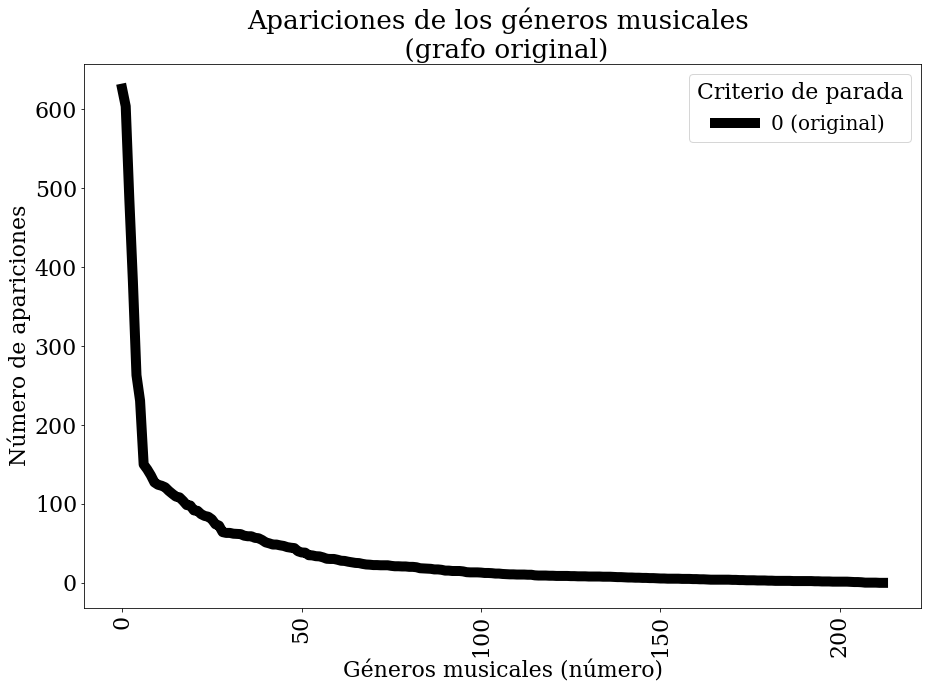

In [9]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(G_pl_total_counts, color="black", linewidth=10, label = "0 (original)")
ax.legend(loc="upper right", title = "Criterio de parada", prop ={'size': 20})
plt.title("Apariciones de los géneros musicales \n (grafo original)")
plt.ylabel("Número de apariciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
plt.savefig("axelrod_original.png")

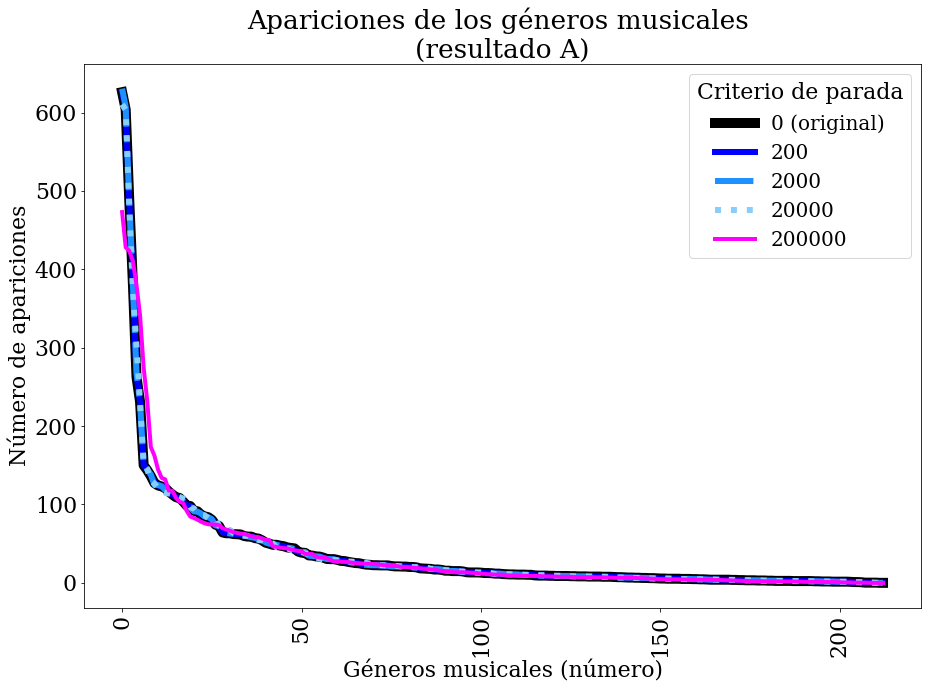

In [10]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(G_pl_total_counts, color="black", linewidth=10, label = "0 (original)")
ax.plot(G_axelrod1_pl_total_counts, color = "b", linewidth = 6, linestyle = '-', label = "200")
ax.plot(G_axelrod2_pl_total_counts, color = "dodgerblue", linewidth = 6, linestyle = '-.', label = "2000")
ax.plot(G_axelrod3_pl_total_counts, color= "lightskyblue", linewidth = 6 ,linestyle = ':', label = "20000")
ax.plot(G_axelrod4_pl_total_counts, color = "magenta", linewidth=4, linestyle = '-', label = "200000")
ax.legend(loc="upper right", title = "Criterio de parada", prop ={'size': 20})
plt.title("Apariciones de los géneros musicales \n(resultado A)")
plt.ylabel("Número de apariciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
plt.savefig("axelrodA.png")

In [11]:
positionsA = get_top_tags(G_pl_total_genres,  G_axelrod4_pl_total_genres, G_pl_total_counts, G_axelrod4_pl_total_counts, list_tags, True)


0. alternative (4, +4, 263, 473,  +210)
1. indie (2, +1, 486, 428,  -58)
2. pop rock (32, +30, 62, 423,  +361)
3. pop (1, -2, 603, 410,  -193)
4. rock (0, -4, 626, 380,  -245)
5. electronic (3, -2, 382, 341,  -41)
6. new wave (17, +11, 103, 274,  +170)
7. hip-hop (5, -2, 230, 232,  +1)
8. trip-hop (37, +29, 57, 173,  +116)
9. indie rock (9, 0, 127, 162,  +35)
10. classic rock (7, -3, 143, 144,  +1)
11. jazz (22, +11, 87, 134,  +47)
12. progressive metal (39, +27, 54, 132,  +77)
13. ambient (16, +3, 108, 117,  +9)
14. ska-punk (130, +116, 8, 117,  +109)
15. punk (8, -7, 136, 108,  -27)
16. experimental (15, -1, 109, 103,  -5)
17. folk (6, -11, 150, 101,  -48)
18. rap (13, -5, 116, 91,  -24)
19. metalcore (25, +6, 80, 84,  +4)
20. alt-country (94, +74, 15, 82,  +67)
21. hard rock (14, -7, 112, 80,  -32)
22. blues (33, +11, 61, 78,  +16)
23. hardcore (20, -3, 91, 76,  -15)
24. industrial (23, -1, 84, 74,  -10)
25. soundtrack (21, -4, 91, 74,  -16)
26. metal (18, -8, 98, 74,  -24)
27. euro

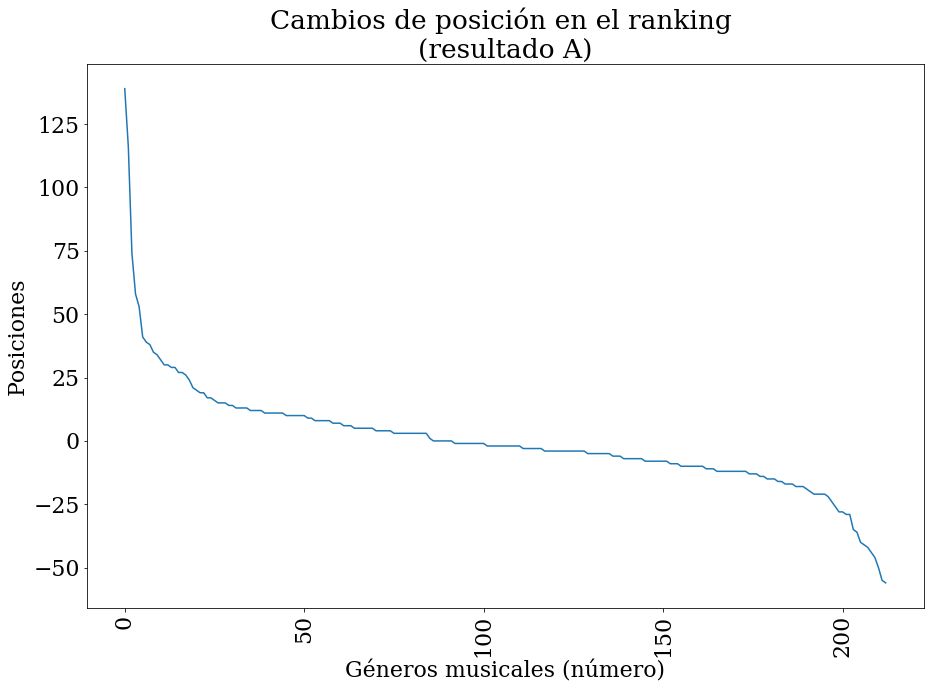

In [12]:
print_positionsA = get_positions(positionsA)
plt.figure(figsize=(15,10))
plt.plot(print_positionsA)
plt.title("Cambios de posición en el ranking \n(resultado A)")
plt.ylabel("Posiciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
plt.savefig("positionsA.jpg")

## Prueba B

In [13]:
#G = generate_graph(m, df_artists, 0)
#G_axelrod1B = axelrod(G,200)
#G_axelrod2B = axelrod(G_axelrod1B,2000)
#G_axelrod3B = axelrod(G_axelrod2B,20000)
#G_axelrod4B = axelrod(G_axelrod3B,200000)

In [14]:
#G_pl_total_genres, G_pl_total_counts = get_complete_genres_counts(G, list_tags)
#G_axelrod1B_pl_total_genres, G_axelrod1B_pl_total_counts = get_complete_genres_counts(G_axelrod1B, list_tags)
#G_axelrod2B_pl_total_genres, G_axelrod2B_pl_total_counts = get_complete_genres_counts(G_axelrod2B, list_tags)
#G_axelrod3B_pl_total_genres, G_axelrod3B_pl_total_counts = get_complete_genres_counts(G_axelrod3B, list_tags)
#G_axelrod4B_pl_total_genres, G_axelrod4B_pl_total_counts = get_complete_genres_counts(G_axelrod4B, list_tags)

In [15]:
num_de_cambios = []
G_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'pop punk', 'heavy metal', 'emo', 'pop rock', 'blues', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'screamo', 'shoegaze', 'gothic metal', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'darkwave', 'christian rock', 'folk metal', 'blues rock', 'symphonic metal', 'house', 'gothic', 'lo-fi', 'grindcore', 'doom metal', 'underground hip-hop', 'trance', 'latin pop', 'electropop', 'new age', 'bossa nova', 'hardcore punk', 'glam rock', 'minimal', 'melodic hardcore', 'futurepop', 'gothic rock', 'glam metal', 'garage rock', 'disco', 'chanson', 'alt-country', 'contemporary country', 'rockabilly', 'electroclash', 'dream pop', 'dark electro', 'techno', 'drum and bass', 'disney', 'stoner', 'technical death metal', 'anime', 'musical', 'dancehall', 'psychedelic rock', 'brutal death metal', 'rapcore', 'math rock', 'composer', 'psytrance', 'avant-garde', 'dubstep', 'speed metal', 'rock n roll', 'psychobilly', 'swing', 'new rave', 'sludge metal', 'noise rock', 'gospel', 'dub', 'opera', 'contemporary classical', 'industrial rock', 'horror punk', 'dark ambient', 'ska-punk', 'samba', 'piano rock', 'deathrock', 'soft rock', 'reggaeton', 'drone', 'viking metal', 'southern rock', 'celtic', 'alternative metal', 'lounge', 'ethereal', 'neo soul', 'mathcore', 'southern rap', 'gangsta rap', 'folk rock', 'breakcore', 'ethnic', 'medieval', '8-bit', 'neofolk', 'grime', 'art rock', 'acid jazz', 'symphonic black metal', 'new romantic', 'groove metal', 'ragga', 'atmospheric black metal', 'noise', 'east coast rap', 'worship', 'post-metal', 'indie folk', 'eurodance', 'easy listening', 'chicago blues', 'bebop', 'minimal techno', 'latin rock', 'teen pop', 'minimalism', 'space rock', 'post-grunge', 'glitch', 'twee pop', 'trancecore', 'psybient', 'roots reggae', 'country pop', 'sleaze rock', 'progressive trance', 'pagan metal', 'folk punk', 'avant-garde metal', 'vocal trance', 'surf rock', 'proto-punk', 'orchestral', 'neoclassical', 'melodic metalcore', 'urban', 'freak folk', 'noisecore', 'noise pop', 'electric blues', 'indietronica', 'crunk', 'country rock', 'breakbeat', 'acoustic rock', 'alternative hip-hop', 'nu jazz', 'jazz hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech')
G_pl_total_counts = (626.0, 603.75, 486.75, 382.0, 263.0, 230.75, 150.0, 143.75, 136.25, 127.25, 124.25, 123.0, 121.0, 116.5, 112.75, 109.25, 108.25, 103.75, 98.5, 98.0, 91.75, 91.25, 87.0, 84.75, 83.75, 80.5, 74.25, 72.5, 64.25, 63.25, 63.25, 62.25, 62.0, 61.75, 59.75, 59.0, 59.0, 57.0, 56.5, 54.25, 51.25, 50.0, 48.5, 48.5, 47.5, 46.75, 45.25, 44.5, 44.0, 40.0, 38.5, 38.25, 35.0, 34.75, 33.75, 33.5, 32.25, 30.5, 30.25, 30.25, 29.25, 28.0, 27.75, 26.75, 26.0, 25.25, 25.0, 24.0, 23.25, 23.0, 22.5, 22.5, 22.25, 22.25, 22.25, 21.5, 21.0, 21.0, 20.75, 20.75, 20.25, 20.25, 19.75, 18.5, 18.25, 18.0, 17.75, 17.0, 17.0, 16.5, 15.5, 15.5, 15.0, 15.0, 15.0, 14.5, 13.5, 13.25, 13.25, 13.25, 13.0, 12.5, 12.5, 12.25, 11.75, 11.75, 11.25, 11.0, 10.75, 10.75, 10.5, 10.5, 10.5, 10.25, 10.25, 9.5, 9.25, 9.25, 9.25, 9.0, 9.0, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 7.75, 7.75, 7.75, 7.5, 7.25, 7.25, 7.0, 6.75, 6.75, 6.5, 6.5, 6.25, 6.25, 6.0, 6.0, 5.75, 5.5, 5.5, 5.25, 5.25, 5.25, 5.25, 5.0, 5.0, 5.0, 4.75, 4.75, 4.5, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 3.0, 2.75, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.5, 1.25, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0) 
G_axelrod1B_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'indie rock', 'dance', 'alternative rock', 'rnb', 'rap', 'hard rock', 'experimental', 'ambient', 'new wave', 'metal', 'soul', 'hardcore', 'soundtrack', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'progressive rock', 'instrumental', 'country', 'pop punk', 'heavy metal', 'emo', 'pop rock', 'blues', 'post-punk', 'synth pop', 'death metal', 'trip-hop', 'indie pop', 'progressive metal', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'chillout', 'melodic death metal', 'deathcore', 'k-pop', 'funk', 'shoegaze', 'gothic metal', 'screamo', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'christian', 'world', 'grunge', 'darkwave', 'christian rock', 'folk metal', 'blues rock', 'symphonic metal', 'house', 'gothic', 'lo-fi', 'underground hip-hop', 'grindcore', 'doom metal', 'latin pop', 'electropop', 'trance', 'new age', 'bossa nova', 'hardcore punk', 'glam rock', 'minimal', 'melodic hardcore', 'futurepop', 'gothic rock', 'glam metal', 'garage rock', 'disco', 'chanson', 'alt-country', 'contemporary country', 'rockabilly', 'electroclash', 'dream pop', 'dark electro', 'techno', 'drum and bass', 'disney', 'stoner', 'technical death metal', 'anime', 'musical', 'dancehall', 'brutal death metal', 'rapcore', 'math rock', 'composer', 'psytrance', 'psychedelic rock', 'avant-garde', 'dubstep', 'speed metal', 'rock n roll', 'psychobilly', 'swing', 'new rave', 'sludge metal', 'noise rock', 'gospel', 'dub', 'opera', 'contemporary classical', 'industrial rock', 'horror punk', 'dark ambient', 'ska-punk', 'samba', 'piano rock', 'deathrock', 'soft rock', 'reggaeton', 'drone', 'viking metal', 'southern rock', 'celtic', 'alternative metal', 'lounge', 'ethereal', 'neo soul', 'mathcore', 'southern rap', 'gangsta rap', 'breakcore', 'folk rock', 'ethnic', 'medieval', '8-bit', 'neofolk', 'grime', 'art rock', 'acid jazz', 'symphonic black metal', 'new romantic', 'groove metal', 'ragga', 'atmospheric black metal', 'noise', 'east coast rap', 'worship', 'post-metal', 'eurodance', 'easy listening', 'chicago blues', 'bebop', 'minimal techno', 'latin rock', 'indie folk', 'teen pop', 'minimalism', 'space rock', 'post-grunge', 'glitch', 'twee pop', 'trancecore', 'psybient', 'roots reggae', 'sleaze rock', 'progressive trance', 'pagan metal', 'folk punk', 'country pop', 'avant-garde metal', 'vocal trance', 'surf rock', 'proto-punk', 'orchestral', 'neoclassical', 'melodic metalcore', 'urban', 'freak folk', 'noisecore', 'noise pop', 'electric blues', 'crunk', 'indietronica', 'country rock', 'breakbeat', 'acoustic rock', 'nu jazz', 'jazz hop', 'alternative hip-hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech')
G_axelrod1B_pl_total_counts = (627.25, 605.0, 488.25, 382.25, 264.25, 230.5, 149.0, 143.0, 135.5, 128.0, 124.25, 123.25, 121.5, 116.5, 113.5, 109.25, 108.25, 104.0, 98.5, 97.0, 91.75, 91.0, 87.0, 84.75, 83.75, 80.5, 74.5, 72.5, 64.25, 63.5, 63.25, 62.0, 61.75, 61.5, 59.75, 59.25, 59.0, 57.0, 55.75, 54.25, 51.0, 50.0, 48.5, 48.5, 47.5, 46.75, 45.25, 44.5, 44.0, 40.0, 38.5, 38.25, 35.0, 34.75, 33.75, 33.5, 32.25, 30.25, 30.25, 30.0, 29.0, 28.0, 27.5, 26.75, 26.0, 25.25, 25.0, 25.0, 23.25, 23.0, 22.5, 22.5, 22.25, 22.25, 22.25, 21.5, 21.0, 21.0, 21.0, 20.25, 20.25, 19.75, 19.75, 18.5, 18.25, 18.0, 17.75, 17.0, 17.0, 16.5, 15.5, 15.0, 15.0, 15.0, 15.0, 14.5, 13.5, 13.25, 13.25, 13.25, 13.0, 12.5, 12.5, 12.25, 11.75, 11.75, 11.0, 11.0, 10.75, 10.5, 10.5, 10.5, 10.25, 10.25, 10.25, 9.5, 9.25, 9.25, 9.25, 9.0, 9.0, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 7.75, 7.75, 7.75, 7.5, 7.25, 7.25, 7.0, 6.75, 6.75, 6.5, 6.5, 6.25, 6.25, 6.0, 5.75, 5.75, 5.5, 5.5, 5.25, 5.25, 5.25, 5.25, 5.0, 5.0, 5.0, 4.75, 4.75, 4.5, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 3.0, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 1.75, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0)
G_axelrod2B_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'folk', 'classic rock', 'punk', 'dance', 'indie rock', 'hard rock', 'alternative rock', 'rap', 'rnb', 'experimental', 'ambient', 'new wave', 'soul', 'metal', 'soundtrack', 'hardcore', 'jazz', 'industrial', 'post-hardcore', 'metalcore', 'instrumental', 'progressive rock', 'heavy metal', 'country', 'pop punk', 'blues', 'emo', 'pop rock', 'post-punk', 'death metal', 'synth pop', 'trip-hop', 'progressive metal', 'indie pop', 'mpb', 'post-rock', 'ebm', 'black metal', 'j-pop', 'idm', 'thrash metal', 'classical', 'britpop', 'reggae', 'power metal', 'j-rock', 'melodic death metal', 'chillout', 'deathcore', 'k-pop', 'funk', 'shoegaze', 'gothic metal', 'screamo', 'ska', 'power pop', 'psychedelic', 'nu metal', 'industrial metal', 'grunge', 'christian', 'world', 'house', 'blues rock', 'folk metal', 'gothic', 'darkwave', 'christian rock', 'symphonic metal', 'lo-fi', 'electropop', 'doom metal', 'latin pop', 'underground hip-hop', 'grindcore', 'new age', 'trance', 'bossa nova', 'hardcore punk', 'minimal', 'gothic rock', 'melodic hardcore', 'glam rock', 'futurepop', 'glam metal', 'chanson', 'garage rock', 'contemporary country', 'rockabilly', 'electroclash', 'disco', 'dream pop', 'dark electro', 'disney', 'alt-country', 'techno', 'drum and bass', 'technical death metal', 'anime', 'dancehall', 'psychedelic rock', 'musical', 'stoner', 'rapcore', 'math rock', 'composer', 'brutal death metal', 'psytrance', 'avant-garde', 'speed metal', 'gospel', 'dubstep', 'rock n roll', 'psychobilly', 'swing', 'samba', 'noise rock', 'new rave', 'dub', 'sludge metal', 'opera', 'contemporary classical', 'piano rock', 'horror punk', 'dark ambient', 'southern rap', 'ska-punk', 'deathrock', 'soft rock', 'reggaeton', 'industrial rock', 'drone', 'viking metal', 'southern rock', 'celtic', 'alternative metal', 'neo soul', 'lounge', 'gangsta rap', 'folk rock', 'ethereal', 'mathcore', 'breakcore', 'ethnic', 'medieval', '8-bit', 'neofolk', 'grime', 'art rock', 'acid jazz', 'groove metal', 'ragga', 'new romantic', 'atmospheric black metal', 'symphonic black metal', 'post-grunge', 'worship', 'noise', 'indie folk', 'east coast rap', 'post-metal', 'eurodance', 'easy listening', 'chicago blues', 'bebop', 'minimal techno', 'latin rock', 'teen pop', 'minimalism', 'twee pop', 'space rock', 'glitch', 'trancecore', 'psybient', 'roots reggae', 'sleaze rock', 'pagan metal', 'folk punk', 'country pop', 'avant-garde metal', 'vocal trance', 'surf rock', 'proto-punk', 'progressive trance', 'orchestral', 'neoclassical', 'melodic metalcore', 'urban', 'noisecore', 'noise pop', 'freak folk', 'electric blues', 'indietronica', 'crunk', 'country rock', 'breakbeat', 'acoustic rock', 'nu jazz', 'jazz hop', 'alternative hip-hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'west coast rap', 'aggrotech')
G_axelrod2B_pl_total_counts = (628.0, 598.5, 487.0, 392.0, 264.25, 227.75, 152.5, 144.5, 135.75, 129.25, 128.5, 119.0, 118.25, 117.25, 116.5, 108.25, 108.25, 103.0, 102.5, 96.5, 91.75, 91.0, 87.25, 86.0, 82.75, 79.75, 73.5, 73.0, 64.25, 63.5, 62.25, 61.25, 60.75, 60.0, 59.5, 59.0, 58.25, 57.5, 54.75, 54.75, 50.75, 49.5, 48.5, 47.75, 47.5, 46.75, 45.25, 44.5, 43.0, 40.0, 38.5, 38.5, 35.0, 35.0, 33.75, 32.5, 32.25, 30.5, 30.25, 29.5, 28.75, 28.0, 27.75, 27.25, 26.5, 25.75, 25.5, 25.0, 23.5, 23.0, 22.5, 22.25, 22.25, 22.25, 22.0, 21.25, 21.25, 21.0, 20.75, 20.5, 20.5, 19.75, 19.0, 18.5, 18.25, 17.5, 17.5, 16.75, 16.75, 16.5, 15.75, 15.5, 15.0, 14.5, 13.5, 13.5, 13.5, 13.25, 13.25, 13.0, 13.0, 12.5, 12.5, 11.75, 11.75, 11.5, 11.25, 11.25, 10.5, 10.5, 10.5, 10.5, 10.5, 10.25, 10.25, 9.75, 9.5, 9.5, 9.25, 9.25, 9.0, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.5, 8.25, 8.25, 8.25, 8.0, 8.0, 8.0, 7.75, 7.75, 7.75, 7.75, 7.5, 7.25, 7.25, 7.0, 6.75, 6.75, 6.75, 6.75, 6.75, 6.5, 6.0, 5.75, 5.5, 5.5, 5.25, 5.25, 5.25, 5.25, 5.0, 4.75, 4.75, 4.75, 4.5, 4.5, 4.25, 4.25, 4.25, 4.25, 4.0, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 3.0, 2.75, 2.5, 2.5, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 1.75, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 0.75, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0)
G_axelrod3B_pl_total_genres = ('rock', 'pop', 'indie', 'electronic', 'alternative', 'hip-hop', 'classic rock', 'folk', 'hard rock', 'indie rock', 'punk', 'dance', 'rap', 'soul', 'rnb', 'alternative rock', 'experimental', 'ambient', 'new wave', 'soundtrack', 'metal', 'hardcore', 'industrial', 'jazz', 'post-hardcore', 'metalcore', 'instrumental', 'pop punk', 'progressive rock', 'country', 'progressive metal', 'trip-hop', 'blues', 'emo', 'death metal', 'heavy metal', 'post-punk', 'mpb', 'synth pop', 'post-rock', 'pop rock', 'ebm', 'j-pop', 'idm', 'indie pop', 'black metal', 'classical', 'reggae', 'power metal', 'melodic death metal', 'thrash metal', 'j-rock', 'britpop', 'deathcore', 'chillout', 'funk', 'gothic metal', 'k-pop', 'shoegaze', 'grunge', 'psychedelic', 'screamo', 'industrial metal', 'ska', 'world', 'christian', 'nu metal', 'power pop', 'doom metal', 'house', 'blues rock', 'darkwave', 'symphonic metal', 'latin pop', 'trance', 'grindcore', 'christian rock', 'folk metal', 'gothic', 'minimal', 'new age', 'lo-fi', 'underground hip-hop', 'hardcore punk', 'electropop', 'bossa nova', 'glam rock', 'gothic rock', 'futurepop', 'gospel', 'rockabilly', 'melodic hardcore', 'dark electro', 'glam metal', 'contemporary country', 'techno', 'garage rock', 'chanson', 'disco', 'disney', 'brutal death metal', 'drum and bass', 'horror punk', 'rock n roll', 'electroclash', 'technical death metal', 'composer', 'anime', 'psychedelic rock', 'dream pop', 'math rock', 'alt-country', 'alternative metal', 'stoner', 'psytrance', 'dancehall', 'musical', 'southern rap', 'soft rock', 'speed metal', 'rapcore', 'psychobilly', 'avant-garde', 'southern rock', 'noise rock', 'dark ambient', 'swing', 'gangsta rap', 'dub', 'dubstep', 'ska-punk', 'samba', 'viking metal', 'sludge metal', 'opera', 'contemporary classical', 'new rave', 'drone', 'reggaeton', 'piano rock', 'mathcore', 'industrial rock', 'celtic', 'folk rock', 'deathrock', 'ethereal', 'symphonic black metal', 'neo soul', 'lounge', 'medieval', 'art rock', 'ethnic', 'noise', 'neofolk', 'atmospheric black metal', '8-bit', 'ragga', 'post-grunge', 'acid jazz', 'indie folk', 'breakcore', 'worship', 'new romantic', 'grime', 'easy listening', 'bebop', 'minimalism', 'minimal techno', 'glitch', 'post-metal', 'groove metal', 'space rock', 'latin rock', 'teen pop', 'psybient', 'chicago blues', 'trancecore', 'sleaze rock', 'roots reggae', 'folk punk', 'eurodance', 'east coast rap', 'avant-garde metal', 'alternative hip-hop', 'vocal trance', 'twee pop', 'surf rock', 'proto-punk', 'progressive trance', 'pagan metal', 'orchestral', 'neoclassical', 'electric blues', 'country pop', 'melodic metalcore', 'noisecore', 'noise pop', 'country rock', 'urban', 'indietronica', 'acoustic rock', 'freak folk', 'crunk', 'breakbeat', 'nu jazz', 'jazz hop', 'classical crossover', 'electro-industrial', 'electro house', 'contemporary christian', 'west coast rap', 'christian metalcore', 'aggrotech')
G_axelrod3B_pl_total_counts = (660.0, 592.5, 478.0, 400.0, 256.0, 222.75, 176.25, 154.75, 152.25, 143.5, 127.75, 119.25, 117.75, 116.25, 112.75, 109.25, 107.0, 100.0, 98.25, 93.75, 93.0, 88.0, 87.25, 87.0, 84.25, 75.0, 72.25, 71.0, 68.5, 64.0, 62.25, 61.0, 58.25, 57.75, 57.25, 55.75, 55.5, 55.25, 52.5, 52.0, 51.25, 51.0, 50.0, 48.5, 46.75, 46.75, 46.25, 40.75, 40.75, 39.5, 39.0, 37.0, 37.0, 33.25, 33.25, 32.0, 29.25, 29.0, 28.75, 28.25, 27.75, 27.5, 27.25, 25.75, 25.25, 25.0, 24.0, 23.75, 23.0, 22.75, 22.75, 22.5, 22.25, 21.5, 20.5, 20.5, 20.5, 20.25, 20.0, 19.25, 19.0, 19.0, 18.5, 18.25, 18.0, 17.25, 17.0, 16.25, 16.25, 16.0, 15.25, 15.25, 15.25, 15.0, 15.0, 14.5, 14.5, 14.0, 13.5, 13.0, 13.0, 12.75, 12.0, 11.75, 11.75, 11.5, 11.5, 11.5, 11.25, 11.0, 10.75, 10.75, 10.5, 10.25, 10.25, 10.25, 10.0, 9.75, 9.75, 9.5, 9.5, 9.25, 9.25, 9.0, 9.0, 9.0, 8.75, 8.75, 8.75, 8.5, 8.25, 8.25, 8.0, 8.0, 8.0, 8.0, 7.75, 7.75, 7.5, 7.5, 7.5, 7.25, 7.25, 7.0, 7.0, 6.75, 6.25, 6.0, 6.0, 5.75, 5.75, 5.5, 5.25, 5.25, 5.25, 5.25, 4.75, 4.75, 4.75, 4.5, 4.5, 4.25, 4.0, 4.0, 4.0, 4.0, 3.75, 3.75, 3.75, 3.5, 3.5, 3.25, 3.25, 3.0, 3.0, 3.0, 2.75, 2.75, 2.75, 2.75, 2.75, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.0, 1.75, 1.75, 1.75, 1.5, 1.25, 1.25, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0)
G_axelrod4B_pl_total_genres = ('rock', 'hard rock', 'electronic', 'pop', 'indie', 'classic rock', 'pop punk', 'industrial', 'hip-hop', 'alternative', 'folk', 'progressive rock', 'dance', 'rap', 'nu metal', 'soul', 'indie rock', 'progressive metal', 'punk', 'experimental', 'stoner', 'new wave', 'post-hardcore', 'jazz', 'ambient', 'rnb', 'soundtrack', 'idm', 'hardcore', 'metal', 'metalcore', 'post-rock', 'instrumental', 'trip-hop', 'alternative rock', 'ebm', 'country', 'j-pop', 'blues', 'death metal', 'hardcore punk', 'black metal', 'post-punk', 'classical', 'emo', 'heavy metal', 'synth pop', 'melodic death metal', 'rock n roll', 'reggae', 'mpb', 'gothic metal', 'deathcore', 'power metal', 'j-rock', 'industrial metal', 'indie pop', 'thrash metal', 'blues rock', 'world', 'power pop', 'shoegaze', 'k-pop', 'darkwave', 'psychedelic rock', 'funk', 'folk metal', 'pop rock', 'christian', 'ska', 'horror punk', 'britpop', 'lo-fi', 'christian rock', 'chillout', 'symphonic metal', 'doom metal', 'grunge', 'grindcore', 'screamo', 'contemporary country', 'psychedelic', 'house', 'bossa nova', 'underground hip-hop', 'minimal', 'trance', 'chanson', 'melodic hardcore', 'new age', 'drum and bass', 'gospel', 'rockabilly', 'glam rock', 'electropop', 'technical death metal', 'composer', 'dub', 'rapcore', 'gothic', 'anime', 'techno', 'psychobilly', 'gothic rock', 'dancehall', 'speed metal', 'alt-country', 'noise rock', 'gangsta rap', 'folk rock', 'disco', 'brutal death metal', 'noise', 'musical', 'math rock', 'dark ambient', 'psytrance', 'latin pop', 'ethereal', 'sludge metal', 'opera', 'garage rock', 'dream pop', 'country pop', 'new rave', 'minimalism', 'electroclash', 'reggaeton', 'glam metal', 'contemporary classical', 'avant-garde', 'dark electro', 'ska-punk', 'futurepop', 'acid jazz', 'samba', 'new romantic', 'viking metal', 'swing', 'ethnic', 'celtic', 'southern rock', 'grime', 'drone', 'neo soul', 'medieval', 'disney', 'symphonic black metal', 'lounge', 'dubstep', '8-bit', 'ragga', 'neofolk', 'chicago blues', 'alternative metal', 'southern rap', 'glitch', 'indie folk', 'atmospheric black metal', 'east coast rap', 'post-metal', 'piano rock', 'deathrock', 'art rock', 'worship', 'industrial rock', 'easy listening', 'mathcore', 'soft rock', 'noisecore', 'melodic metalcore', 'pagan metal', 'orchestral', 'breakcore', 'roots reggae', 'proto-punk', 'post-grunge', 'groove metal', 'vocal trance', 'space rock', 'psybient', 'latin rock', 'folk punk', 'country rock', 'avant-garde metal', 'urban', 'twee pop', 'surf rock', 'sleaze rock', 'progressive trance', 'noise pop', 'neoclassical', 'minimal techno', 'eurodance', 'bebop', 'trancecore', 'teen pop', 'electric blues', 'acoustic rock', 'indietronica', 'jazz hop', 'crunk', 'classical crossover', 'nu jazz', 'freak folk', 'breakbeat', 'west coast rap', 'electro-industrial', 'electro house', 'contemporary christian', 'christian metalcore', 'alternative hip-hop', 'aggrotech') 
G_axelrod4B_pl_total_counts = (696.25, 466.0, 444.75, 412.0, 376.0, 337.5, 295.0, 214.0, 192.5, 169.75, 124.5, 117.25, 114.25, 105.25, 105.25, 101.5, 100.75, 98.25, 89.25, 86.5, 85.25, 85.25, 84.5, 84.25, 83.75, 82.5, 80.25, 79.5, 76.25, 64.0, 61.25, 61.0, 61.0, 59.5, 55.75, 55.25, 52.75, 50.75, 50.25, 46.0, 44.25, 43.5, 43.25, 43.0, 41.25, 41.0, 37.0, 36.25, 35.25, 34.75, 34.5, 34.5, 33.25, 32.25, 31.0, 31.0, 30.5, 29.5, 28.75, 26.25, 25.25, 25.0, 24.75, 24.25, 23.75, 23.5, 23.0, 22.75, 22.75, 22.25, 22.25, 21.25, 21.0, 20.75, 20.75, 20.0, 18.75, 18.25, 18.0, 17.75, 17.25, 16.25, 16.0, 15.5, 15.25, 15.0, 14.75, 14.5, 14.0, 13.75, 12.75, 12.25, 12.0, 12.0, 12.0, 11.5, 11.25, 11.0, 10.75, 10.75, 10.5, 10.25, 10.25, 10.25, 10.0, 9.75, 9.75, 9.5, 9.5, 9.0, 9.0, 9.0, 8.75, 8.75, 8.75, 8.75, 8.5, 8.5, 8.25, 7.75, 7.75, 7.75, 7.75, 7.75, 7.5, 7.5, 7.5, 7.25, 7.25, 7.25, 7.25, 6.75, 6.5, 6.5, 6.25, 6.0, 6.0, 5.75, 5.75, 5.75, 5.75, 5.5, 5.5, 5.5, 5.25, 5.0, 5.0, 4.75, 4.75, 4.75, 4.75, 4.5, 4.5, 4.5, 4.5, 4.25, 4.25, 4.0, 4.0, 3.75, 3.5, 3.5, 3.5, 3.5, 3.25, 3.25, 3.25, 3.0, 2.75, 2.75, 2.75, 2.5, 2.5, 2.5, 2.25, 2.25, 2.25, 2.25, 2.0, 2.0, 2.0, 2.0, 1.75, 1.75, 1.75, 1.5, 1.5, 1.5, 1.5, 1.5, 1.25, 1.25, 1.25, 1.25, 1.25, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

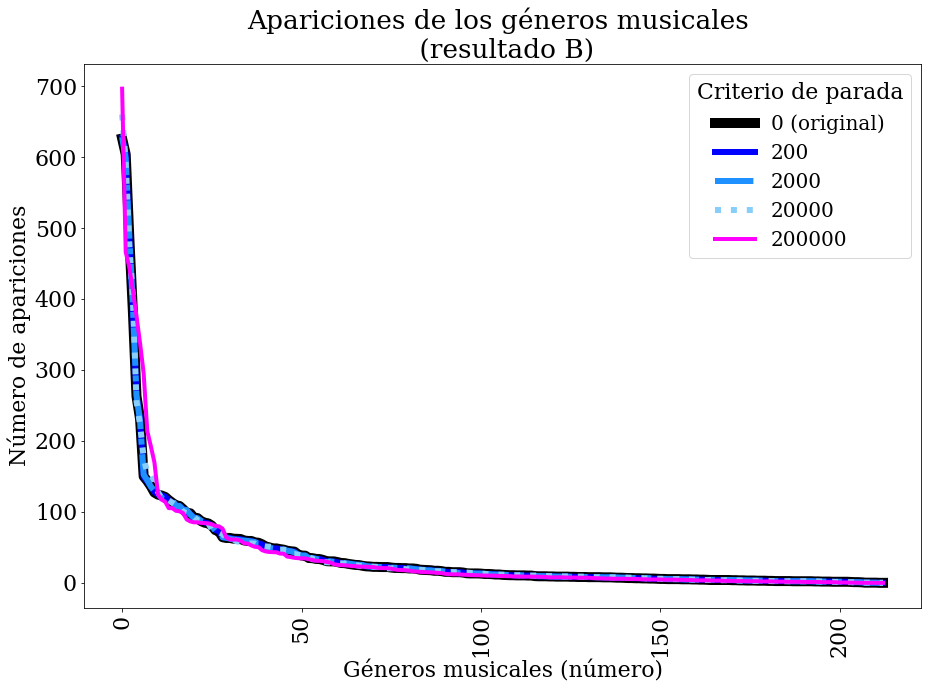

In [16]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(G_pl_total_counts, color="black", linewidth=10, label = "0 (original)")
ax.plot(G_axelrod1B_pl_total_counts, color = "b", linewidth = 6, linestyle = '-', label = "200")
ax.plot(G_axelrod2B_pl_total_counts, color = "dodgerblue", linewidth = 6, linestyle = '-.', label = "2000")
ax.plot(G_axelrod3B_pl_total_counts, color= "lightskyblue", linewidth = 6 ,linestyle = ':', label = "20000")
ax.plot(G_axelrod4B_pl_total_counts, color = "magenta", linewidth=4, linestyle = '-', label = "200000")
ax.legend(loc="upper right", title = "Criterio de parada", prop ={'size': 20})
plt.title("Apariciones de los géneros musicales \n (resultado B)")
plt.ylabel("Número de apariciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
plt.savefig("axelrodB.png")

In [17]:
positionsB = get_top_tags(G_pl_total_genres,  G_axelrod4B_pl_total_genres, G_pl_total_counts, G_axelrod4B_pl_total_counts, list_tags, True)

0. rock (0, 0, 626, 696,  +70)
1. hard rock (14, +13, 112, 466,  +353)
2. electronic (3, +1, 382, 444,  +62)
3. pop (1, -2, 603, 412,  -191)
4. indie (2, -2, 486, 376,  -110)
5. classic rock (7, +2, 143, 337,  +193)
6. pop punk (29, +23, 63, 295,  +231)
7. industrial (23, +16, 84, 214,  +129)
8. hip-hop (5, -3, 230, 192,  -38)
9. alternative (4, -5, 263, 169,  -93)
10. folk (6, -4, 150, 124,  -25)
11. progressive rock (26, +15, 74, 117,  +43)
12. dance (10, -2, 124, 114,  -10)
13. rap (13, 0, 116, 105,  -11)
14. nu metal (63, +49, 26, 105,  +78)
15. soul (19, +4, 98, 101,  +3)
16. indie rock (9, -7, 127, 100,  -26)
17. progressive metal (39, +22, 54, 98,  +44)
18. punk (8, -10, 136, 89,  -47)
19. experimental (15, -4, 109, 86,  -22)
20. stoner (103, +83, 12, 85,  +73)
21. new wave (17, -4, 103, 85,  -18)
22. post-hardcore (24, +2, 83, 84,  0)
23. jazz (22, -1, 87, 84,  -2)
24. ambient (16, -8, 108, 83,  -24)
25. rnb (12, -13, 121, 82,  -38)
26. soundtrack (21, -5, 91, 80,  -11)
27. idm

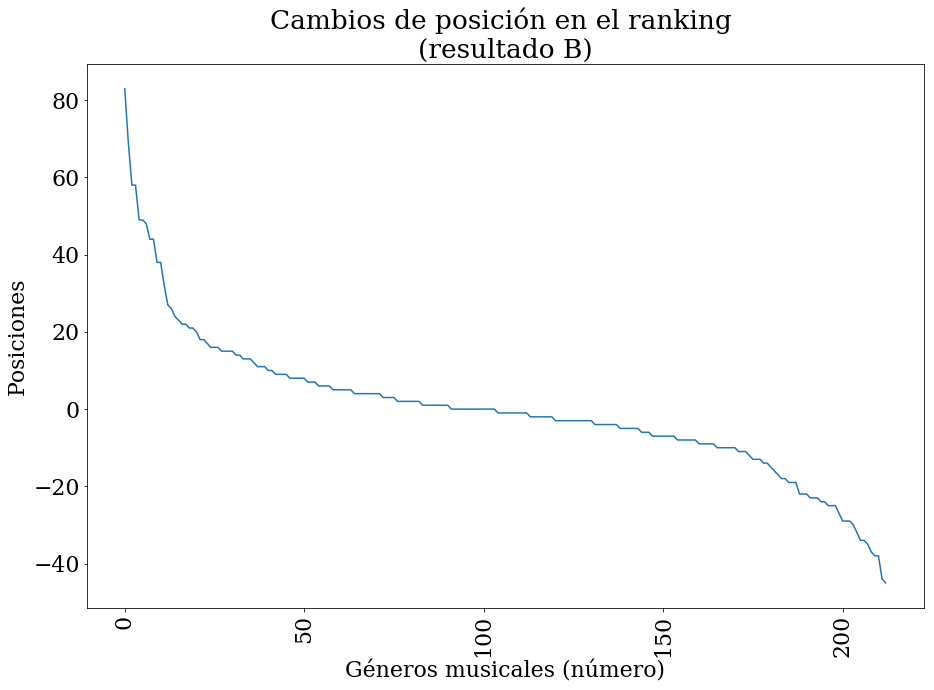

In [18]:
print_positionsB = get_positions(positionsB)
plt.figure(figsize=(15,10))
plt.plot(print_positionsB)
plt.title("Cambios de posición en el ranking \n(resultado B)")
plt.ylabel("Posiciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
plt.savefig("positionsB.jpg")

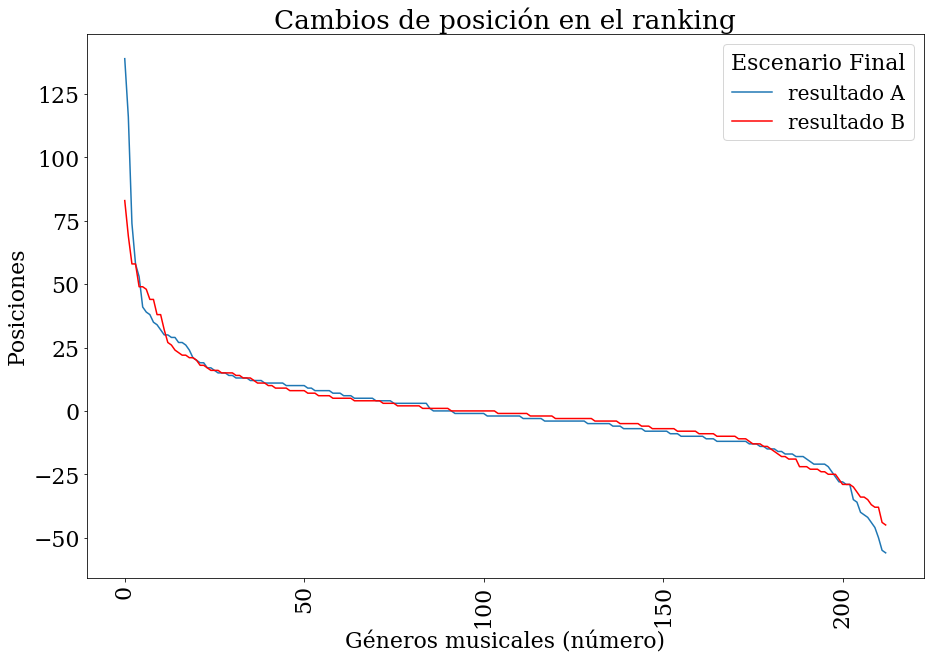

In [21]:
font = {'family' : 'serif',
        'size'   : 22}
plt.rc('font', **font)
fig, ax = plt.subplots(1, figsize=(15,10))

plt.plot(print_positionsA, label = "resultado A")
plt.plot(print_positionsB, label = "resultado B", color = "red")
plt.title("Cambios de posición en el ranking")
plt.ylabel("Posiciones")
plt.xlabel("Géneros musicales (número)")
plt.xticks(rotation='vertical')
ax.legend(loc="upper right", title = "Escenario Final", prop ={'size': 20})
plt.savefig("positionsAB.jpg")